## install any packages here 

In [86]:
import pandas as pd
import numpy as np

# utility
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate

#viz
import seaborn as sns
import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# parallel
import ray

try:
    ray.shutdown()
except:
    print("ray not started")

ray.init()

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, LeaveOneOut, KFold
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler
# from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA, NMF
from sklearn.compose import ColumnTransformer

import altair
import altair as alt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import copy
from skorch import NeuralNetClassifier
import torch.optim as optim
import optuna
from optuna.integration import OptunaSearchCV
# from mlxtend.feature_selection import SequentialFeatureSelector
# from tensorflow.keras.callbacks import EarlyStopping

# models
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, RidgeClassifier, LinearRegression
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from lineartree import LinearTreeClassifier, LinearForestClassifier, LinearBoostClassifier


# analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None) # show all cols

# from data_cleaning import clean_raw_data, create_dataset, get_all_results

from data_cleaning import clean_raw_data, create_dataset
from sklearn.ensemble import ExtraTreesClassifier
from mango import Tuner

RESULTS_DIR = "results/"
DATA_DIR = "data/"
SEED = 42

# reload modules in py files
%load_ext autoreload
%autoreload 2

2023-04-26 19:51:59,004	INFO worker.py:1553 -- Started a local Ray instance.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# ray.shutdown()

In [88]:
# !pip install linear-tree

In [89]:
# !pip uninstall --yes mlxtend

## clean dataset using functions in src/data_cleaning.py

In [90]:
X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
print("No missing values in X: ", (X.isna().sum() == 0).all())
print("No missing values in y: ", (y.isna().sum() == 0).all())

print(X.columns)
display(X.head(5),X.shape ,y.head(5), y.shape)

print(y.value_counts())

/home/mmoschit/Concussions-and-Athletic-Performance/src
No missing values in X:  True
No missing values in y:  True
Index(['age', 'DOB_d', 'concussions', 'weight', 'bimanualscore_washer', 'RT_V',
       'RT_HR', 'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_V', 'TMT_HR',
       'CMT_V', 'CMT_HR', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR',
       'BallPath_V', 'BallPath_HR', 'FullPath_V', 'FullPath_HR',
       'Delta_Fullpath', 'Corrective_V', 'Corrective_HR', 'PeakV_V',
       'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR',
       'AbsOnAxis_HR', 'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR',
       'Delta_OffAxis', 'AbsOnAxis_V'],
      dtype='object')


age      DOB_d  concussions  weight  bimanualscore_washer        RT_V  \
0   18  27.608487          1.0     193                 20.54  426.570000   
2   18  27.225188          1.0     196                 20.20  398.272727   
3   18  27.408624          1.0     178                 17.20  663.000000   
4   18  27.356605          1.0     202                 24.00  490.080000   
5   18  27.178645          1.0     220                 20.00  340.120000   

       RT_HR  Delta_RT      MT_V     MT_HR  Delta_MT     TMT_V     TMT_HR  \
0   680.8300    254.26  241.7300  895.6200    653.90  285.4000  1200.6900   
2   541.1175    142.84  259.1539  222.6922    -36.46  265.3636   249.5000   
3  1279.9670    616.97  311.8333  578.4696    266.64  371.2000   912.7325   
4   767.1300    277.06  204.8800  300.9600     96.07  208.7100   760.9400   
5   614.8100    274.69  161.1400  163.4500      2.31  350.9500   161.4600   

    CMT_V  CMT_HR  cvRT_V  cvRT_HR  stdRT_V  stdRT_HR  BallPath_V  \
0   43.67  305.07    0.10     0.21    42.79    140.47       64.82   
2    6.21   26.81    0.09     0.28    34.58    151.09       69.48   
3   59.37  334.26    0.92     0.82   609.51   1051.09       69.52   
4    3.83  459.98    0.08     0.12    38.93     92.45       66.88   
5  189.80   -1.99    0.12     0.04    41.03     25.22       65.26   

   BallPath_HR  FullPath_V  FullPath_HR  Delta_Fullpath  Corrective_V  \
0        66.62       70.00        77.51            7.50          5.18   
2        62.36       69.73        73.17            3.44          0.25   
3        64.02       69.52        79.74           10.22          0.00   
4        65.63       69.12        81.85           12.73          2.24   
5        68.21       69.27        68.21           -1.06          4.01   

   Corrective_HR  PeakV_V  PeakV_HR  Delta_PV   AE_V  AE_HR  Delta_AE  VE_V  \
0          10.89   211.89     64.68   -147.21   9.71  15.44      5.73  5.02   
2          10.81   195.69    238.35     42.66   5.22   6.07      0.84  4.13   
3          15.72   457.96    128.81   -329.16   3.96  12.62      8.66  0.94   
4          16.22   250.68    195.37    -55.30   8.99  13.42      4.42  2.35   
5           0.00   318.08    368.13     50.05  11.48   5.24     -6.24  9.66   

   VE_HR  AbsOnAxis_HR  Delta_OnAxis  AbsOffAxis_V  AbsOffAxis_HR  \
0   8.77     10.940000          2.92      3.790000       7.560000   
2   0.83     11.610000          8.50      1.940000       0.790000   
3   5.22     13.250000         10.11      1.580000       8.260000   
4   8.92      8.597285          1.15      1.791101       6.231146   
5   0.00      5.731523          0.55      3.657617       2.941176   

   Delta_OffAxis  AbsOnAxis_V  
0           3.77     8.010000  
2          -1.15     3.110000  
3           6.67     3.140000  
4           4.44     7.447210  
5          -0.72     5.184766

(117, 40)

0    0
2    0
3    0
4    0
5    0
Name: NHL, dtype: int64

(117,)

1    69
0    48
Name: NHL, dtype: int64


In [91]:
sampler = RandomUnderSampler(random_state=42, sampling_strategy={0 : 48, 1 : 47})
X_resampled, y_resampled = sampler.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape, y_resampled.value_counts())

(95, 40) (95,) 0    48
1    47
Name: NHL, dtype: int64


## Model Tuning

1. Take best features from feature selection 
2. Tune model using best features 


In [92]:
class NamedFeatureSelector(object):

    def __init__(self, column_names):
        all_col_names = ['age', 'concussions', 'weight',
        'bimanualscore_washer', 'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'MT_HR',
        'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT: V', 'CMT: HR', 'cvRT_V', 'cvRT_HR',
        'stdRT_V', 'stdRT_HR', 'Ball Path_V', 'Ball Path_HR', 'FullPath_V',
        'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'Corrective_HR',
        'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V',
        'VE_HR', 'AbsOnAxis_HR', 'Delta_OnAxis', 'AbsOffAxis_V',
        'AbsOffAxis_HR', 'Delta_OffAxis', 'AbsOnAxis_V'
        ]

        self.column_names = column_names
        self.column_idx = [all_col_names.index(col_name) for col_name in column_names]

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, self.column_idx]
            return X.to_numpy()
        else:
            X = X[:, self.column_idx]
            return X
    
    def fit(self, X, y=None):
        return self
    
        
    
    
    
# features_sel = NamedFeatureSelector(["age as of June 1", '# of concussions', 'weight'])
# X, y = create_dataset(clean_raw_data("Brdi_db_march.xlsx"), target_col="NHL")
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=1, stratify=y)
# display(X_train)
# features_sel.transform(X_train)

#### Scale Certain Columns

In [93]:
X, y_ = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")

columns_to_exclude = ['DOB_d', 'age', 'weight', 'bimanualscore_washer']
cols_to_scale = np.setdiff1d(X.columns, columns_to_exclude).tolist()

# Define your column transformer
myStandardScaler = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('StandardScaler', StandardScaler(), cols_to_scale),
    ],
    n_jobs=-1,  
)

myRobustScaler = ColumnTransformer(
    transformers=[
        ('RobustScaler', RobustScaler(), cols_to_scale),
    ],
    remainder='passthrough',  # Pass through any columns not specified in transformers
    n_jobs=-1,  # Use all available CPU cores for parallel processing
)

myMinMaxScaler = ColumnTransformer(
    transformers=[
        ('MinMaxScaler', MinMaxScaler(), cols_to_scale),
    ],
    remainder='passthrough',  # Pass through any columns not specified in transformers
    n_jobs=-1,  # Use all available CPU cores for parallel processing
)

pipeline = Pipeline([('scaler', myStandardScaler)])

X_transformed = pipeline.fit_transform(X)

# Get the names of the columns after scaling
# Get the names of the columns after scaling
X_scaled = pd.DataFrame(X_transformed, columns=[col.split("__")[1] for col in myStandardScaler.get_feature_names_out()])
display(X_scaled.head())
print("No missing values in X_scaled: ", (X_scaled.isna().sum() == 0).all())


/home/mmoschit/Concussions-and-Athletic-Performance/src


AE_HR      AE_V  AbsOffAxis_HR  AbsOffAxis_V  AbsOnAxis_HR  AbsOnAxis_V  \
0  0.251493  0.270306       1.353275      1.478797     -0.231113     0.275587   
1 -1.508454 -1.142320      -1.665465     -0.264719     -0.116495    -1.082748   
2 -0.278181 -1.538736       1.665405     -0.603998      0.164064    -1.074432   
3 -0.127919  0.043783       0.760740     -0.405048     -0.631887     0.119575   
4 -1.664351  0.827177      -0.706257      1.354034     -1.122140    -0.507600   

   BallPath_HR  BallPath_V    CMT_HR     CMT_V  Corrective_HR  Corrective_V  \
0     0.252754   -0.429148  0.284197  0.082761       0.031874      0.528028   
1    -0.332377    0.716971 -1.284961 -0.629177       0.021842     -0.841327   
2    -0.104368    0.726809  0.448805  0.381144       0.637525     -0.910767   
3     0.116773    0.077505  1.157762 -0.674410       0.700221     -0.288585   
4     0.471148   -0.320931 -1.447370  2.860002      -1.333663      0.203049   

   Delta_AE  Delta_Fullpath  Delta_MT  Delta_OffAxis  Delta_OnAxis  Delta_PV  \
0  0.080239        0.207656  1.884469       0.640833     -0.350384 -1.405665   
1 -0.737777       -0.229562 -0.934204      -1.509496      0.479538  1.795269   
2  0.570379        0.500572  0.303324       1.908303      0.718996 -4.473079   
3 -0.138902        0.770872 -0.393097       0.933662     -0.613638  0.143805   
4 -1.922144       -0.714165 -0.775910      -1.321561     -0.702877  1.919854   

   Delta_RT  FullPath_HR  FullPath_V     MT_HR      MT_V  PeakV_HR   PeakV_V  \
0  0.825266     0.233557    0.045701  1.506836 -0.416388 -1.467112 -0.192141   
1 -0.144857    -0.250488   -0.033037 -0.899480 -0.235706  1.157360 -0.419288   
2  3.983347     0.482272   -0.094277  0.372741  0.310571 -0.497990  3.258109   
3  1.023784     0.717603   -0.210926 -0.619603 -0.798517  0.507853  0.351749   
4  1.003148    -0.803683   -0.167183 -1.111324 -1.252093  3.118573  1.296793   

      RT_HR      RT_V    TMT_HR     TMT_V     VE_HR      VE_V  concussions  \
0  0.704729 -0.115374  1.297444 -0.354907  0.371295 -0.343836     0.673905   
1 -0.447987 -0.463871 -1.318403 -0.553545 -1.787109 -0.607385     0.673905   
2  5.647984  2.796392  0.505539  0.495698 -0.593734 -1.552015     0.673905   
3  1.416758  0.666787  0.088097 -1.115198  0.412071 -1.134483     0.673905   
4  0.160023 -1.180054 -1.560520  0.294943 -2.012736  1.030171     0.673905   

    cvRT_HR    cvRT_V  stdRT_HR   stdRT_V   age      DOB_d  weight  \
0  0.219078 -0.386393  0.217448 -0.318117  18.0  27.608487   193.0   
1  0.949259 -0.422161  0.319882 -0.357742  18.0  27.225188   196.0   
2  6.582086  2.546511  9.000785  2.417128  18.0  27.408624   178.0   
3 -0.719727 -0.457928 -0.245727 -0.336747  18.0  27.356605   202.0   
4 -1.554219 -0.314859 -0.894190 -0.326611  18.0  27.178645   220.0   

   bimanualscore_washer  
0                 20.54  
1                 20.20  
2                 17.20  
3                 24.00  
4                 20.00

No missing values in X_scaled:  True


#### Define Custom Optuna Distribution Class

Optuna requires that each parameter in the param_dist dict is of their distribution type. <br> We define a class that conforms to a distribution type in order to create distributions of objects/classes such as the scaling classes (ColumnTransformer) and undersampler (RandomUnderSampler)

In [105]:
class CustomDistribution(optuna.distributions.CategoricalDistribution):
    def __init__(self, choices):
        self.choices = choices
        self.size = len(choices)

    def single(self):
        return self.choices[0]

    def to_external_repr(self, internal_repr):
        return self.choices[internal_repr]

    def to_internal_repr(self, external_repr):
        return self.choices.index(external_repr)

# ex
# scaler_dist = CustomDistribution([myStandardScaler])

#### Dimensionality Reduction using Principle component analysis

/home/mmoschit/Concussions-and-Athletic-Performance/src


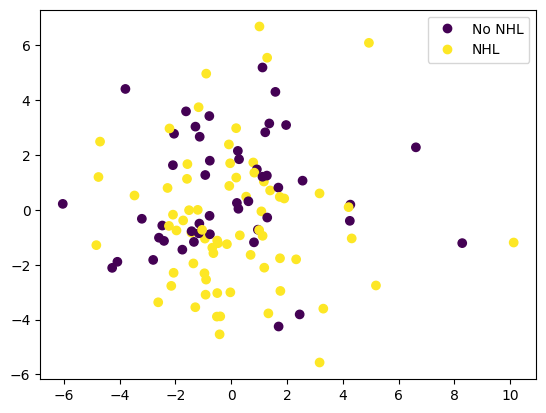

In [95]:
X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
pca = PCA(n_components=.8, random_state=SEED)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=['No NHL', 'NHL'])
plt.show()

## function to get different types of cross validation

In [96]:
def get_cross_validation(X, y, test_size=.2, n_splits=10, type="stratified", random_state=SEED):
    if type == "stratified":
        return list(StratifiedShuffleSplit(test_size=test_size, n_splits=n_splits, random_state=random_state).split(X, y))
    elif type == "leave_one_out":
        return list(LeaveOneOut().split(X, y))
    elif type=="K-Fold":
        return list(KFold(n_splits=n_splits, random_state=random_state, shuffle=True).split(X, y))

In [97]:
def seaborn_conf_matrix(cm, model_name, result_dir="../figures/confusion_matricies"):
    plt.figure()
    plt.title(f"{model_name} Confusion Matrix")
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{result_dir}/{model_name}_conf_matrix.png")

## Tuning Setup

In [98]:
def graph_cv_results(results_df):
    plt.figure()
    # Plot loss scores using seaborn
    
    plt.xticks(rotation=90)
    sns.lineplot(data=results_df, x='params', y='mean_train_score', label='CV Training Score')
    sns.lineplot(data=results_df, x='params', y='mean_test_score', label='CV Test Score')
    plt.xlabel('')
    plt.xticks(ticks=[], labels=[])

In [99]:
from sklearn.metrics import make_scorer

def scorer(*args):
    print(args)
    y_pred = clf.predict(X)
    score = f1_score(y, y_pred)
#     return score
    return 1


overfitting_scorer = make_scorer(scorer, greater_is_better=True)

In [100]:
def create_classification_report_DF(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    report_df = pd.DataFrame(report).transpose()

    return report_df


create_classification_report_DF(list([0,0,0,0,0,0,0,0]), list([1,1,1,1,1,1,1,1]))

precision  recall  f1-score  support
0                   0.0     0.0       0.0      8.0
1                   0.0     0.0       0.0      0.0
accuracy            0.0     0.0       0.0      0.0
macro avg           0.0     0.0       0.0      8.0
weighted avg        0.0     0.0       0.0      8.0

### Tune Model
Note: The decorator "@ray.remote" is useful to run different seeds in parallel using the ray python package

In [101]:
scoring_dict = {

            "F1_unweighted" : "f1",
            "F1_weighted" : make_scorer(f1_score, average="weighted"),
            "F1_0" : make_scorer(f1_score, labels=[0], average=None),
            "F1_1" : make_scorer(f1_score, labels=[1], average=None),

            "Precision_unweighted" :  make_scorer(precision_score, zero_division=0),
            "Precision_weighted" : make_scorer(precision_score, zero_division=0, average="weighted"),
            "Precision_0" : make_scorer(precision_score,labels=[0], zero_division=0),
            "Precision_1" : make_scorer(precision_score,labels=[1], zero_division=0),

            "Recall_unweighted" : make_scorer(recall_score, zero_division=0),
            "Recall_weighted" : make_scorer(recall_score, zero_division=0, average="weighted"),
            "Recall_0" : make_scorer(recall_score, labels=[0], zero_division=0),
            "Recall_1" : make_scorer(recall_score, labels=[1], zero_division=0),
        }

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import make_scorer
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
@ray.remote
def tune_model(model, param_dist, features=None, n_iter=200, target_col=None, random_state=SEED, scoring="F1_unweighted", search_type="random"):
    model_name = type(model).__name__
    if "Bagging" in model_name or "Ada" in model_name:
        model_name = model_name + "_" + model.estimator.__class__.__name__

    X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col=target_col)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=random_state, stratify=y)
  
    cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=random_state)

    pipe = ImbPipeline([
            ('scaler', "passthrough"),
            ('selector', "passthrough"),
            ('model', model)
        ])

    print("SCORING:  ", scoring)
#    setup hyperparameter search using Sklearn random search 
    if search_type == "random":
        param_search = RandomizedSearchCV(pipe, 
                                            param_distributions=param_dist, 
                                            cv=cv,
                                            n_iter=n_iter,
                                            random_state=random_state,
                                            return_train_score=True,
                                            scoring=scoring_dict,
                                            n_jobs=-1,
                                            refit=scoring)
    elif search_type == "tpe":
        pipe = ImbPipeline([
            ('scaler', myStandardScaler),
            ('selector', "passthrough"),
            ('model', model)
        ])
        param_search = OptunaSearchCV(pipe, 
                                       param_distributions=param_dist,
                                       cv=cv,
                                       n_trials=n_iter,
                                       random_state=random_state,
                                       return_train_score=True,
                                       scoring=scoring_dict[scoring],
                                       n_jobs=-1,
                                       refit=True,
                                       enable_pruning=True
                                           
        )

#   run randomsearch looking for best param configuration on training data
    param_search.fit(X_train, y_train)
    best_estimator = param_search.best_estimator_
#   Once hyperparameter search is complete, predict on validation data using best configuration

# Save the resulting image to a file
    if "tree" in model_name and "Bag" not in model_name and "Ada" not in model_name:
        tree = best_estimator.named_steps['model']
        export_graphviz(tree,
                     out_file=f"../figures/graph_viz/tree_{model_name}.dot",
                     feature_names = X_train.columns, 
                     class_names=["Did not play", "Played in the NHL"],
                     filled = True)
        
#     if "Lin" in model_name or "Lin" in model_name:
#         plt.figure(figsize=(10,6))
#         tree = best_estimator.named_steps['model']
#         tree.plot_model()
#         plt.savefig('../figures/graph_viz/linear_tree.png')
    
#     get training classification report
    y_pred_train = best_estimator.predict(X_train)
    train_report_df = create_classification_report_DF(y_train, y_pred_train)
#     print(f"Classification Report from training: {tabulate(train_report_df, headers='keys', tablefmt='psql')}")    
    
#     get validation classification report
    y_pred_val = best_estimator.predict(X_val)

    search_type_str = "Random" if search_type == 'random' else 'Tree-Parzen Estimator'
    print(f"Search Type: {search_type_str}")
    print(f"y val : {np.array(y_val)}")
    print(f"y pred: {y_pred_val}")
    weighted_f1 = f1_score(y_val, y_pred_val, average='weighted')
    print(f"Weighted F1: {weighted_f1}")
    
    val_report_df = create_classification_report_DF(y_val, y_pred_val)
#     print(f"Val classification report: {tabulate(val_report_df, headers='keys', tablefmt='psql')}")
    
#     collect estimator, params, and seed
    estimator_df = pd.DataFrame([{
                            "Best Estimator" : param_search.best_estimator_,
                            "Best Params" : param_search.best_params_, 
                            "Best Score" : param_search.best_score_,
                            "Search Type" : search_type_str,
                            "Seed" : random_state,
                            "Train F1 Weighted " : train_report_df.loc["weighted avg", "f1-score"],
                            "Test F1 Weighted " : val_report_df.loc["weighted avg", "f1-score"],
                            "Y Val" : np.array(y_val),
                            "Y Pred" : y_pred_val
                    }])
    
    
    return estimator_df, train_report_df, val_report_df
    

### Tune Model Sequential
Exact copy of tune_model, but without ray.remote() decorator, few modifications for mlp_torch

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import make_scorer
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def tune_model_sequential(model, param_dist, features=None, n_iter=200, target_col=None, random_state=SEED, scoring="F1_unweighted", search_type="random"):
    model_name = type(model).__name__
    if "Bagging" in model_name or "Ada" in model_name:
        model_name = model_name + "_" + model.estimator.__class__.__name__

    X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col=target_col)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=random_state, stratify=y)
  
    cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=random_state)

    #     convert to tensors if pytorch model
    if "NeuralNet" in type(model).__name__:
        X_train = torch.FloatTensor(X_train.values).to(torch.float64)
        X_val = torch.FloatTensor(X_val.values).to(torch.float64)
        y_train = torch.FloatTensor(y_train.values).to(torch.float64)
        
    pipe = ImbPipeline([
            ('scaler', "passthrough"),
            ('selector', "passthrough"),
            ('model', model)
        ])

    print("SCORING:  ", scoring)
#    setup hyperparameter search using Sklearn random search 
    if search_type == "random":
        param_search = RandomizedSearchCV(pipe, 
                                            param_distributions=param_dist, 
                                            cv=cv,
                                            n_iter=n_iter,
                                            random_state=random_state,
                                            return_train_score=True,
                                            scoring=scoring_dict,
                                            n_jobs=-1,
                                            refit=scoring)
    elif search_type == "tpe":
        pipe = ImbPipeline([
            ('scaler', myStandardScaler),
            ('selector', "passthrough"),
            ('model', model)
        ])
        param_search = OptunaSearchCV(pipe, 
                                       param_distributions=param_dist,
                                       cv=cv,
                                       n_trials=n_iter,
                                       random_state=random_state,
                                       return_train_score=True,
                                       scoring=scoring_dict[scoring],
                                       n_jobs=-1,
                                       refit=True,
                                       enable_pruning=True
                                           
        )

#   run randomsearch looking for best param configuration on training data
    param_search.fit(X_train, y_train)
    best_estimator = param_search.best_estimator_
#   Once hyperparameter search is complete, predict on validation data using best configuration

# Save the resulting image to a file
    if "tree" in model_name and "Bag" not in model_name and "Ada" not in model_name:
        tree = best_estimator.named_steps['model']
        export_graphviz(tree,
                     out_file=f"../figures/graph_viz/tree_{model_name}.dot",
                     feature_names = X_train.columns, 
                     class_names=["Did not play", "Played in the NHL"],
                     filled = True)
        
#     if "Lin" in model_name or "Lin" in model_name:
#         plt.figure(figsize=(10,6))
#         tree = best_estimator.named_steps['model']
#         tree.plot_model()
#         plt.savefig('../figures/graph_viz/linear_tree.png')
    
#     get training classification report
    y_pred_train = best_estimator.predict(X_train)
    train_report_df = create_classification_report_DF(y_train, y_pred_train)
#     print(f"Classification Report from training: {tabulate(train_report_df, headers='keys', tablefmt='psql')}")    
    
#     get validation classification report
    y_pred_val = best_estimator.predict(X_val)

    search_type_str = "Random" if search_type == 'random' else 'Tree-Parzen Estimator'
    print(f"Search Type: {search_type_str}")
    print(f"y val : {np.array(y_val)}")
    print(f"y pred: {y_pred_val}")
    weighted_f1 = f1_score(y_val, y_pred_val, average='weighted')
    print(f"Weighted F1: {weighted_f1}")
    
    val_report_df = create_classification_report_DF(y_val, y_pred_val)
#     print(f"Val classification report: {tabulate(val_report_df, headers='keys', tablefmt='psql')}")
    
#     collect estimator, params, and seed
    estimator_df = pd.DataFrame([{
                            "Best Estimator" : param_search.best_estimator_,
                            "Best Params" : param_search.best_params_, 
                            "Best Score" : param_search.best_score_,
                            "Search Type" : search_type_str,
                            "Seed" : random_state,
                            "Train F1 Weighted " : train_report_df.loc["weighted avg", "f1-score"],
                            "Test F1 Weighted " : val_report_df.loc["weighted avg", "f1-score"],
                            "Y Val" : np.array(y_val),
                            "Y Pred" : y_pred_val
                    }])
    
    
    return estimator_df, train_report_df, val_report_df
    

### Paralell Tune Loop

In [148]:
from time import time

def outer_tune_loop(model, param_dist, n_iter=None,target_col="NHL", elastic_net=False, scoring="F1_unweighted", parallel=True, search_type="random"):
    start = time()
    model_name = type(model).__name__
    if elastic_net == True:
        if "Bag" in model_name:
            model_name = "BaggingClassifier_ElasticNet"
        elif "Ada" in model_name:
            model_name = "AdaBoostClassifier_ElasticNet"
        else:
            model_name = "ElasticNet"
            
    elif "Bagging" in model_name or "Ada" in model_name:
        model_name = model_name + "_" + model.estimator.__class__.__name__
        
    model_name = model_name + "_" + search_type + "search"
        

    # random_states = [1, 10, 42, 69, 77, 11, 23, 99, 58, 91]
    random_states = [42, 69, 23, 99, 89]
#     random_states = [42, 89]
#     random_states = [42]

    estimator_dfs = pd.DataFrame()
    training_report_dfs = pd.DataFrame()
    val_report_dfs = pd.DataFrame()

    if parallel:
        print("Parallelizing with Ray")
        result_ids = [tune_model.remote(clone(model), param_dist, n_iter=n_iter, target_col="NHL", random_state=random_states[i], scoring=scoring, search_type=search_type) for i in range(len(random_states))]
        print(f"len result ids: {len(result_ids)}")

        for estimator_df, training_report_df, val_report_df in ray.get(result_ids):

    #         collect each of the three dfs for one seed
            estimator_dfs = pd.concat([estimator_dfs, estimator_df])
            training_report_dfs = pd.concat([training_report_dfs, training_report_df])
            val_report_dfs = pd.concat([val_report_dfs, val_report_df])  
          
    else:
        print("Running Sequentially")
        for seed in random_states:
            estimator_df, training_report_df, val_report_df = tune_model_sequential(clone(model), param_dist, n_iter=n_iter, target_col="NHL", random_state=seed, scoring=scoring, search_type=search_type)

        #         collect each of the three dfs for one seed
            estimator_dfs = pd.concat([estimator_dfs, estimator_df])
            training_report_dfs = pd.concat([training_report_dfs, training_report_df])
            val_report_dfs = pd.concat([val_report_dfs, val_report_df])    


    
#     val_f1 = round(outer_loop_results['Validation F1'].mean(), 3)
#     val_precision = round(outer_loop_results['Validation Precision'].mean(), 3)
#     val_recall = round(outer_loop_results['Validation Recall'].mean(), 3)

#     print(f"Mean Validation Score Across {len(random_states)} trials: {val_f1}")
#     print(f"Mean Validation Precision Across {len(random_states)} trials: {val_precision}")
#     print(f"Mean Validation Recall Across {len(random_states)} trials: {val_recall}")
   
        
#     outer_loop_results.to_excel(f"../{RESULTS_DIR}{model_name}.xlsx", index=False)
#     print(f"Training time for {len(random_states)} seeds: {round(time() - start, 3)}")
#     return outer_loop_results

    estimator_dfs.to_excel(f"../{RESULTS_DIR}{model_name}-estimator_df.xlsx", index=True)
    training_report_dfs.to_excel(f"../{RESULTS_DIR}{model_name}-train_df.xlsx", index=True)
    val_report_dfs.to_excel(f"../{RESULTS_DIR}{model_name}-val_df.xlsx", index=True)
    
    return estimator_dfs, training_report_dfs.groupby(training_report_dfs.index).mean(), val_report_dfs.groupby(val_report_dfs.index).mean()

## SVC

### TPE SVC

In [ ]:
model = SVC(random_state=SEED, class_weight='balanced')
param_dist = {
    "selector" : CustomDistribution([
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ]),
    'scaler' : CustomDistribution[myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__C': optuna.distributions.FloatDistribution(.001, 10, log=True),
    "model__gamma" : optuna.distributions.IntLogUniformDistribution(1, 100),
    'model__kernel': optuna.distributions.CategoricalDistribution(['rbf', "linear", "poly", "sigmoid"]),
}


svc_est_tpe, svc_train_tpe, svc_val_tpe = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", scoring="F1_weighted", parallel=False, search_type="tpe")


#### TPE SVC Results

In [ ]:
display(svc_train_tpe, svc_val_tpe)

In [ ]:
model = SVC(random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__C': [.0001, .001, 1, 5, 10],
    "model__gamma" : [1, 5, 10, 50, 100],
    'model__kernel': ['rbf', "linear", "poly", "sigmoid"],
    "model__class_weight" : ["balanced"],
}


svc_est, svc_train, svc_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=500,target_col="NHL", scoring="F1_weighted")


#### SVC Results

In [ ]:
display(svc_est, svc_train, svc_val)

In [ ]:
model = BaggingClassifier(estimator=SVC(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
                    None,
#                     SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#                     SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                    NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                    NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age",'Delta_MT', 'AbsOffAxis_V', 'AbsOffAxis_HR', "Delta_OffAxis"])
            ],
        'scaler' : [myStandardScaler,],
        'model__estimator__C': [1, .7],
        'model__estimator__kernel': ['rbf', "sigmoid"],
        'model__n_estimators': [200, 300, 500],
        "model__estimator__class_weight" : ["balanced"]
    }

bag_svc_est,bag_svc_train,bag_svc_val  = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", scoring="F1_weighted")

#### Bagged SVC Results

In [ ]:
display(bag_svc_est, bag_svc_train, bag_svc_val)

In [ ]:
model = AdaBoostClassifier(estimator=SVC(random_state=SEED), random_state=SEED, algorithm='SAMME')
param_dist = {
        "selector" : [
                    None,
#                     SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#                     SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                    NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
            ],
        'scaler' : [myStandardScaler],
        'model__estimator__C': [.0001, .001, 1, 5],
        'model__estimator__kernel': ['rbf', "sigmoid"],
        'model__n_estimators': [200, 300, 500],
        "model__estimator__class_weight" : ["balanced"]
    }

boost_svc_est, boost_svc_train, boost_svc_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Boosted SVC Results

In [ ]:
display(boost_svc_est, boost_svc_train, boost_svc_val)

## Light Gradient Boosting

### TPE LGM

In [123]:
model = LGBMClassifier(random_state=SEED)
param_dist = {
        'scaler' : CustomDistribution([myStandardScaler, myMinMaxScaler, myRobustScaler, None]),
        "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
        "model__boosting_type" : optuna.distributions.CategoricalDistribution(["dart"]),
#         "model__num_leaves": [2, 5, 7],
#         "model__learning_rate": [.01, .05, .1, .3, ],
#         "model__num_iterations" : [ 300, 400],
#         "model__max_depth": [7],
#         "model__max_bin" : [50, 75, 100, 200],
#         "model__min_data_in_leaf" : [ 30, 40, 45 ],
#         "model__early_stopping_rounds" : [1, 3, 5, 7],
#         "model__min_child_samples": [1, 5, 7],
#         "model__subsample": [0.5, 0.7, 0.9],
#         "model__colsample_bytree": [0.5, 0.7, 0.9],
#         "model__class_weight" : ["balanced"],
#         "model__boosting_type": optuna.distributions.CategoricalDistribution(["dart"]),
        "model__num_leaves": optuna.distributions.IntDistribution(2, 10),
        "model__learning_rate": optuna.distributions.FloatDistribution(.01, .5),
        "model__max_depth": optuna.distributions.IntDistribution(2, 10),
#         "model__max_bin" : [50, 75],
        "model__min_data_in_leaf" : optuna.distributions.IntDistribution(20, 35),
#         "model__early_stopping_rounds" : [1, 3, 5, 7],
#         "model__min_child_samples": [1, 5, 7],
#         "model__subsample": [0.5,],
#         "model__colsample_bytree": [.4, 0.5,],
        "model__class_weight" : optuna.distributions.CategoricalDistribution(["balanced"]),
    }

lgbm_cv_results_est, lgbm_cv_results_train, lgbm_cv_results_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100, parallel=False, target_col="NHL", scoring="F1_weighted", search_type="tpe")

Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 20:16:29,907] A new study created in memory with name: no-name-10fc8d92-1c7e-4497-a54c-0106d4d848c2


SCORING:   F1_weighted
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[

[I 2023-04-26 20:17:29,936] Trial 2 finished with value: 0.5236358091438184 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66df34c910>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min

[I 2023-04-26 20:17:30,788] Trial 35 finished with value: 0.5566211176239444 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66e17a78e0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2023-04-26 20:17:31,081] Trial 45 finished with value: 0.5472910886842776 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 10, 'model__

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2023-04-26 20:17:31,147] Trial 50 finished with value: 0.5302335121691699 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2023-04-26 20:17:31,388] Trial 67 finished with value: 0.5377655989932204 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 8, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:17:31,620] Trial 30 finished with value: 0.5702421480345831 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66dedeb250>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:17:31,879] Trial 42 finished with value: 0.5295706928165537 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66e14b9760>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2023-04-26 20:17:32,221] Trial 51 finished with value: 0.5571024856076007 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 3, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2023-04-26 20:17:32,477] Trial 66 finished with value: 0.5455465718529388 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 3, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:17:32,802] Trial 64 finished with value: 0.568153669867023 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66c42a9670>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2023-04-26 20:17:33,011] Trial 8 finished with value: 0.559061838312747 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 4, 'model__lea

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:17:33,374] Trial 73 finished with value: 0.533008149102509 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 4, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:17:33,720] Trial 54 finished with value: 0.5532568413623737 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66dedd8640>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:17:34,188] Trial 75 finished with value: 0.5702590243396543 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66c4322250>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:17:34,590] Trial 5 finished with value: 0.5522545060270192 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66c4380880>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1]
Weighted F1: 0.43674889310562937
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 20:17:35,735] A new study created in memory with name: no-name-c3af4de8-f46e-41a6-8bef-60007ff86153


SCORING:   F1_weighted
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[

[I 2023-04-26 20:18:31,533] Trial 1 finished with value: 0.5145582246532576 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66def60250>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:18:31,941] Trial 7 finished with value: 0.5229839304142712 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66df1a28b0>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2023-04-26 20:18:32,163] Trial 8 finished with value: 0.5178206083113877 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f668c7d6970>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2023-04-26 20:18:32,653] Trial 12 finished with value: 0.501336240896747 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 2, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-26 20:18:32,838] Trial 30 finished with value: 0.4793155284115036 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 8, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2023-04-26 20:18:33,344] Trial 47 finished with value: 0.5403568462766202 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 2, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:18:33,566] Trial 45 finished with value: 0.5169593993897401 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66df2fc400>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:18:33,805] Trial 28 finished with value: 0.5429401761397993 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66ded3a280>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:18:34,164] Trial 34 finished with value: 0.5334435485395238 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 10, 'model__

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:18:34,341] Trial 38 finished with value: 0.4770884614754583 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2023-04-26 20:18:34,736] Trial 79 finished with value: 0.5510038771596182 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66e16e1400>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:18:35,533] Trial 37 finished with value: 0.47170807743778537 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Search Type: Tree-Parzen Estimator
y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
y pred: [0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0]
Weighted F1: 0.4895104895104894
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 20:18:36,576] A new study created in memory with name: no-name-07446e5f-8ba7-4b52-b257-a16109019856


SCORING:   F1_weighted
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[

[I 2023-04-26 20:19:32,505] Trial 8 finished with value: 0.510453520843883 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 7, 'model__lea

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[I 2023-04-26 20:19:32,912] Trial 12 finished with value: 0.49858439353829037 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f668c7098b0>, 'model__boos

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-26 20:19:33,116] Trial 5 finished with value: 0.5209226952957604 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66e3c0b280>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-26 20:19:33,492] Trial 3 finished with value: 0.464332435620496 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 4, 'model__lea

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2023-04-26 20:19:33,704] Trial 17 finished with value: 0.4669539403627437 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c70d9a0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2023-04-26 20:19:33,975] Trial 7 finished with value: 0.5068233990774036 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66e1598460>, 'model__boosti

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2023-04-26 20:19:34,270] Trial 21 finished with value: 0.46623474040205776 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66a4105a30>, 'model__boos

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-26 20:19:34,620] Trial 37 finished with value: 0.5217531246964549 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 6, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:19:35,194] Trial 36 finished with value: 0.4985269973740832 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 5, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-26 20:19:35,865] Trial 35 finished with value: 0.4625272619873509 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 6, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:19:36,391] Trial 75 finished with value: 0.5083737797178368 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 8, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
Search Type: Tree-Parzen Estimator
y val : [0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0]
y pred: [0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0]
Weighted F1: 0.5
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 20:19:37,323] A new study created in memory with name: no-name-efb59c14-cacb-4b63-897e-9fd195adeff1


SCORING:   F1_weighted
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[

[I 2023-04-26 20:20:34,624] Trial 14 finished with value: 0.5513485119448236 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2023-04-26 20:20:34,829] Trial 4 finished with value: 0.5086856954833803 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 3, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-26 20:20:35,085] Trial 11 finished with value: 0.5249682710612849 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2023-04-26 20:20:35,266] Trial 21 finished with value: 0.5354520679362516 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f668c1864c0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-26 20:20:35,643] Trial 25 finished with value: 0.5195367888867686 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c152a60>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2023-04-26 20:20:35,714] Trial 0 finished with value: 0.5151783550948983 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 8, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-26 20:20:36,018] Trial 24 finished with value: 0.5333336140086713 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c3a2eb0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-26 20:20:36,370] Trial 23 finished with value: 0.5373406555604698 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 2, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:20:36,493] Trial 35 finished with value: 0.48714102320307734 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f668c62c700>, 'model__boos

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:20:36,873] Trial 9 finished with value: 0.5612985782707144 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 5, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2023-04-26 20:20:37,236] Trial 37 finished with value: 0.5090507699177775 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f668c7c1af0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:20:37,890] Trial 91 finished with value: 0.5095770857072512 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c0b88b0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:20:38,287] Trial 94 finished with value: 0.5214817584339054 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c149610>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Search Type: Tree-Parzen Estimator
y val : [0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1]
y pred: [0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0]
Weighted F1: 0.5034965034965034
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 20:20:39,392] A new study created in memory with name: no-name-7cc2d620-6f00-4004-8d7c-a7c1416152e7


SCORING:   F1_weighted
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[

[I 2023-04-26 20:21:36,851] Trial 28 finished with value: 0.5439609573806641 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2023-04-26 20:21:37,186] Trial 13 finished with value: 0.6334406027857368 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 4, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2023-04-26 20:21:37,379] Trial 8 finished with value: 0.5282562212469334 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 9, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-26 20:21:37,784] Trial 4 finished with value: 0.5605513306857364 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 2, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:21:37,904] Trial 2 finished with value: 0.5296835652643972 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 8, 'model__le

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-26 20:21:38,264] Trial 11 finished with value: 0.5466827917399999 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 6, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-26 20:21:38,349] Trial 21 finished with value: 0.5639198088222184 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 6, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:21:38,717] Trial 9 finished with value: 0.538310637075343 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 3, 'model__lea

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2023-04-26 20:21:38,869] Trial 18 finished with value: 0.46756155093616397 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66ded1b550>, 'model__boos

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:21:39,138] Trial 25 finished with value: 0.48845938375350145 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c6a4ac0>, 'model__boos

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:21:39,930] Trial 49 finished with value: 0.5287146468045648 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f66ded0d0a0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-26 20:21:40,276] Trial 26 finished with value: 0.5321805740661576 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 2, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2023-04-26 20:21:40,556] Trial 48 finished with value: 0.4639225514767311 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': <__main__.NamedFeatureSelector object at 0x7f669c0b55b0>, 'model__boost

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-26 20:21:40,970] Trial 78 finished with value: 0.5336888082229312 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': None, 'model__boosting_type': 'dart', 'model__num_leaves': 3, 'model__l

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0]
y pred: [0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1]
Weighted F1: 0.5440917107583775


#### TPE LGM Results

In [126]:
display(lgbm_cv_results_train, lgbm_cv_results_val)

precision    recall  f1-score    support
0              0.673579  0.747368  0.704101  38.000000
1              0.812312  0.741818  0.772828  55.000000
accuracy       0.744086  0.744086  0.744086   0.744086
macro avg      0.742946  0.744593  0.738464  93.000000
weighted avg   0.755626  0.744086  0.744746  93.000000

precision  recall  f1-score  support
0              0.404600     0.5  0.440898     10.0
1              0.590626     0.5  0.533249     14.0
accuracy       0.500000     0.5  0.500000      0.5
macro avg      0.497613     0.5  0.487074     24.0
weighted avg   0.513115     0.5  0.494770     24.0

In [127]:
model = LGBMClassifier(random_state=SEED)
param_dist = {
#         'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
        'scaler' : [myStandardScaler],
        "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
#         "model__boosting_type": ["dart"],
#         "model__num_leaves": [2, 5, 7],
#         "model__learning_rate": [.01, .05, .1, .3, ],
#         "model__num_iterations" : [ 300, 400],
#         "model__max_depth": [7],
#         "model__max_bin" : [50, 75, 100, 200],
#         "model__min_data_in_leaf" : [ 30, 40, 45 ],
#         "model__early_stopping_rounds" : [1, 3, 5, 7],
#         "model__min_child_samples": [1, 5, 7],
#         "model__subsample": [0.5, 0.7, 0.9],
#         "model__colsample_bytree": [0.5, 0.7, 0.9],
#         "model__class_weight" : ["balanced"],
        "model__boosting_type": ["dart"],
        "model__num_leaves": [2, ],
        "model__learning_rate": [.05, .1],
        "model__num_iterations" : [ 300, 400],
        "model__max_depth": [7],
        "model__max_bin" : [50, 75],
        "model__min_data_in_leaf" : [ 25, 30],
        "model__early_stopping_rounds" : [1, 3, 5, 7],
        "model__min_child_samples": [1, 5, 7],
        "model__subsample": [0.5,],
        "model__colsample_bytree": [.4, 0.5,],
        "model__class_weight" : ["balanced"],
    }

lgbm_cv_results_est, lgbm_cv_results_train, lgbm_cv_results_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", parallel=False,scoring="F1_weighted")

Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
Search Type: Random
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1]
Weighted F1: 0.4166666666666667
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted


/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
Search Type: Random
y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
y pred: [0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0]
Weighted F1: 0.40442890442890445
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted


/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
Search Type: Random
y val : [0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0]
y pred: [0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0]
Weighted F1: 0.5
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted


/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


 be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_sample

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


rent value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be igno

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=7, early_stopping_rounds=7 will be ignored. Current value: early_stopping_round=7
[LightGBM] [Warning] min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_

/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=3, early_stopping_rounds=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=30
Search Type: Random
y val : [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0]
y pred: [0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1]
Weighted F1: 0.46115942028985507


#### LGBM Results

In [129]:
display(lgbm_cv_results_train, lgbm_cv_results_val)

precision    recall  f1-score    support
0              0.624235  0.763158  0.686129  38.000000
1              0.805633  0.680000  0.736885  55.000000
accuracy       0.713978  0.713978  0.713978   0.713978
macro avg      0.714934  0.721579  0.711507  93.000000
weighted avg   0.731513  0.713978  0.716146  93.000000

precision    recall  f1-score  support
0              0.397637  0.500000  0.439264   10.000
1              0.557662  0.457143  0.497299   14.000
accuracy       0.475000  0.475000  0.475000    0.475
macro avg      0.477650  0.478571  0.468281   24.000
weighted avg   0.490985  0.475000  0.473118   24.000

In [ ]:
model = BaggingClassifier(estimator=LGBMClassifier(random_state=SEED), random_state=SEED)

param_dist = {
#         'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
        'scaler' : [myMinMaxScaler],
        "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        "model__estimator__boosting_type": ["gbdt", "dart"],
        "model__estimator__num_leaves": [2, 5, 10, 20],
        "model__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__estimator__max_depth": [1, 3, 5, 7],
        "model__estimator__min_child_samples": [1, 5, 10, 20],
        "model__estimator__subsample": [0.5, 0.7, 0.9],
        "model__estimator__colsample_bytree": [0.5, 0.7, 0.9],
        "model__estimator__class_weight" : ["balanced"],
        'model__n_estimators': [5, 10, 50],
        
    }

bagged_lgbm_est, bagged_lgbm_train, bagged_lgbm_est_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", scoring="F1_weighted")

#### Bagged LGBM Results

In [ ]:
display(bagged_lgbm_est, bagged_lgbm_train, bagged_lgbm_est_val)

In [ ]:
model = AdaBoostClassifier(estimator=LGBMClassifier(random_state=SEED), random_state=SEED)

param_dist = {
#         'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
        'scaler' : [myMinMaxScaler],
        "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        "model__estimator__boosting_type": ["gbdt", "dart"],
        "model__estimator__num_leaves": [2, 5, 10, 20],
        "model__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__estimator__max_depth": [1, 3, 5, 7],
        "model__estimator__min_child_samples": [1, 5, 10, 20],
        "model__estimator__subsample": [0.5, 0.7, 0.9],
        "model__estimator__colsample_bytree": [0.5, 0.7, 0.9],
        "model__estimator__class_weight" : ["balanced"],
        'model__n_estimators': [5, 10, 50, 100],
        
    }

boosted_lgbm_cv_results_est, boosted_lgbm_cv_results_train, boosted_lgbm_cv_results_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=500,target_col="NHL")

#### Boosted LGBM Results

In [ ]:
display(boosted_lgbm_cv_results_est, boosted_lgbm_cv_results_train, boosted_lgbm_cv_results_val)

## ElasticNet

### TPE Elastic Net

In [144]:
model = LogisticRegression(random_state=SEED, max_iter=1000, class_weight='balanced')

param_dist = {
    "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
#     'scaler' : CustomDistribution([myMinMaxScaler, myStandardScaler, myRobustScaler]),
    'scaler' : CustomDistribution([myStandardScaler]),
    'model__l1_ratio': optuna.distributions.FloatDistribution(.001, .99, log=True),
    'model__penalty': optuna.distributions.CategoricalDistribution(['elasticnet']),
    'model__solver': optuna.distributions.CategoricalDistribution(['saga']),
}

tpe_el_est, tpe_el_train, tpe_el_val  = outer_tune_loop(model=model, param_dist=param_dist, scoring="F1_weighted" ,n_iter=100, target_col="NHL", elastic_net=True, parallel=False, search_type="tpe")

Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 21:49:19,349] A new study created in memory with name: no-name-5e0faeb0-eec5-4a67-a352-1d264d514acd


SCORING:   F1_weighted


[I 2023-04-26 21:50:02,288] Trial 1 finished with value: 0.5334416176844499 and parameters: {'selector': <__main__.NamedFeatureSelector object at 0x7f6684165220>, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__l1_rat

Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1]
Weighted F1: 0.46115942028985507
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 21:50:13,721] A new study created in memory with name: no-name-3b11a5eb-f75c-4ed5-8b3d-548cd45e9202


SCORING:   F1_weighted


[I 2023-04-26 21:50:58,498] Trial 3 finished with value: 0.5287329042982563 and parameters: {'selector': <__main__.NamedFeatureSelector object at 0x7f668c086940>, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__l1_rat

Search Type: Tree-Parzen Estimator
y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
y pred: [1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1]
Weighted F1: 0.5833333333333334
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 21:51:02,292] A new study created in memory with name: no-name-f4a744bc-63b5-4363-8ed8-379f0b811a84


SCORING:   F1_weighted


[I 2023-04-26 21:51:47,956] Trial 3 finished with value: 0.4803532444806506 and parameters: {'selector': None, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__l1_ratio': 0.0010064091447543, 'model__penalty': 'elasticn

Search Type: Tree-Parzen Estimator
y val : [0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0]
y pred: [0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0]
Weighted F1: 0.6666666666666666
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 21:51:51,748] A new study created in memory with name: no-name-054b11ae-09d3-4ee2-96c7-36e0de74f784


SCORING:   F1_weighted


[I 2023-04-26 21:52:38,441] Trial 1 finished with value: 0.5010660913696314 and parameters: {'selector': <__main__.NamedFeatureSelector object at 0x7f6684257c40>, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__l1_rat

Search Type: Tree-Parzen Estimator
y val : [0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1]
y pred: [0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0]
Weighted F1: 0.5034965034965034
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 21:52:42,163] A new study created in memory with name: no-name-94e0089e-857d-40c2-9fde-e79a62d05297


SCORING:   F1_weighted


[I 2023-04-26 21:53:30,063] Trial 5 finished with value: 0.481689603377583 and parameters: {'selector': <__main__.NamedFeatureSelector object at 0x7f6779b76850>, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__l1_rati

Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0]
y pred: [0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 1]
Weighted F1: 0.5440579710144928


#### TPE Elastic Net Results

In [142]:
display(tpe_el_train, tpe_el_val)

precision    recall  f1-score    support
0              0.600543  0.678947  0.636802  38.000000
1              0.756494  0.687273  0.719762  55.000000
accuracy       0.683871  0.683871  0.683871   0.683871
macro avg      0.678519  0.683110  0.678282  93.000000
weighted avg   0.692772  0.683871  0.685864  93.000000

precision    recall  f1-score    support
0              0.478974  0.540000  0.506166  10.000000
1              0.632035  0.571429  0.598813  14.000000
accuracy       0.558333  0.558333  0.558333   0.558333
macro avg      0.555504  0.555714  0.552490  24.000000
weighted avg   0.568260  0.558333  0.560210  24.000000

In [138]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myMinMaxScaler, myStandardScaler, myRobustScaler],
    'model__l1_ratio': [0.5, .1, .01, .3, .7, .95, .98, .99],
    'model__penalty': ['elasticnet'],
    'model__solver': ['saga'],
    'model__class_weight': ['balanced']
}

lr_cv_results_estimator, lr_cv_results_train, lr_cv_results_val = outer_tune_loop(model=model, param_dist=param_dist, scoring="F1_weighted" ,n_iter=100, target_col="NHL", elastic_net=True)

Parallelizing with Ray
len result ids: 5
(tune_model pid=767621) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=767510) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=767526) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=767623) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=767567) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=767621) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=767621)   warnings.warn(
(tune_model pid=767510) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=767510)   warnings.warn(
(tune_model pid=767526) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=767526)   warnings.warn(
(tune_m

(tune_model pid=767621) SCORING:   F1_weighted
(tune_model pid=767510) SCORING:   F1_weighted
(tune_model pid=767526) SCORING:   F1_weighted
(tune_model pid=767623) SCORING:   F1_weighted
(tune_model pid=767567) SCORING:   F1_weighted
(tune_model pid=767621) Search Type: Random
(tune_model pid=767621) y val : [0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1]
(tune_model pid=767621) y pred: [0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
(tune_model pid=767621) Weighted F1: 0.47142857142857136
(tune_model pid=767510) Search Type: Random
(tune_model pid=767510) y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
(tune_model pid=767510) y pred: [1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1]
(tune_model pid=767510) Weighted F1: 0.5
(tune_model pid=767526) Search Type: Random
(tune_model pid=767526) y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
(tune_model pid=767526) y pred: [1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1]
(tune_model pid=767526) Weighted F1: 0.4534

(tune_model pid=767567) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=767567)   warnings.warn(
(tune_model pid=767526) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=767526)   warnings.warn(
(tune_model pid=767526) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=767526)   warnings.warn(
(tune_model pid=767621) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached whic

#### Elastic Net Results

In [143]:
display(lr_cv_results_train, lr_cv_results_val)

precision    recall  f1-score    support
0              0.535562  0.668421  0.593634  38.000000
1              0.718612  0.592727  0.648425  55.000000
accuracy       0.623656  0.623656  0.623656   0.623656
macro avg      0.627087  0.630574  0.621030  93.000000
weighted avg   0.643817  0.623656  0.626038  93.000000

precision    recall  f1-score    support
0              0.421197  0.560000  0.473791  10.000000
1              0.614892  0.471429  0.520978  14.000000
accuracy       0.508333  0.508333  0.508333   0.508333
macro avg      0.518044  0.515714  0.497385  24.000000
weighted avg   0.534185  0.508333  0.501317  24.000000

In [ ]:
model = BaggingClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False,)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myMinMaxScaler],
    'model__estimator__l1_ratio': [0.5, .1, .01, .001, .7, .95],
    'model__estimator__penalty': ['elasticnet'],
    'model__estimator__solver': ['saga'],
    'model__n_estimators': [5, 10, 50, 100, 300],
    'model__estimator__class_weight': ['balanced']
}

bagged_EL_est, bagged_EL_train, bagged_EL_val  = outer_tune_loop(model=model, param_dist=param_dist, n_iter=50,target_col="NHL", elastic_net=True, scoring="F1_weighted")

#### Bagged ElasticNet Results

In [ ]:
display(bagged_EL_train, bagged_EL_val)

In [ ]:
model = AdaBoostClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False,)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myMinMaxScaler],
    'model__estimator__l1_ratio': [0.5, .1, .01, .001, .7, .95],
    'model__estimator__penalty': ['elasticnet'],
    'model__estimator__solver': ['saga'],
    'model__n_estimators': [5, 10, 50, 100, 300],
    'model__estimator__class_weight': ['balanced']
}

boosted_EL_est, boosted_EL_train, boosted_EL_val,  = outer_tune_loop(model=model, param_dist=param_dist, n_iter=50,scoring="F1_weighted", target_col="NHL", elastic_net=True)

#### Boosted ElasticNet Results

In [ ]:
display(boosted_EL_est, boosted_EL_train, boosted_EL_val)

## Decision Tree

### TPE Decision Tree

In [149]:
model = DecisionTreeClassifier(random_state=SEED)

param_dist = {
        'scaler' : CustomDistribution([myStandardScaler]),
        "selector" : CustomDistribution([RandomUnderSampler(random_state=42)]),
        "model__criterion" : optuna.distributions.CategoricalDistribution(["gini"]),
        "model__max_depth" : optuna.distributions.IntDistribution(2, 8),
        "model__min_samples_split" : optuna.distributions.IntDistribution(8, 15),
        "model__min_samples_leaf" : optuna.distributions.IntDistribution(8, 15),
        "model__max_features" : optuna.distributions.CategoricalDistribution(["sqrt"]),
        "model__class_weight" : optuna.distributions.CategoricalDistribution(["balanced"]),
    }

dt_est_tpe, dt_train_tpe, dt_val_tpe = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=100, target_col="NHL", parallel=False, search_type="tpe")

Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 22:04:10,898] A new study created in memory with name: no-name-be75e1de-35cd-42b9-a49b-31a9eabbff54


SCORING:   F1_weighted


[I 2023-04-26 22:04:56,242] Trial 2 finished with value: 0.5640583012207727 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': RandomUnderSampler(random_state=42), 'model__criterion': 'gini', 'model_

Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1]
Weighted F1: 0.5833333333333334
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 22:05:08,109] A new study created in memory with name: no-name-89cf40e7-4e98-4268-bd99-c341e11d4df7


SCORING:   F1_weighted


[I 2023-04-26 22:06:03,055] Trial 5 finished with value: 0.49988975389486895 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': RandomUnderSampler(random_state=42), 'model__criterion': 'gini', 'model

KeyboardInterrupt: 

#### TPE Decision Tree Results

In [83]:
display(dt_train_tpe, dt_val_tpe)

precision    recall  f1-score    support
0              0.630520  0.715789  0.660835  38.000000
1              0.779517  0.683636  0.718612  55.000000
accuracy       0.696774  0.696774  0.696774   0.696774
macro avg      0.705019  0.699713  0.689724  93.000000
weighted avg   0.718637  0.696774  0.695005  93.000000

precision    recall  f1-score  support
0              0.580000  0.580000  0.565727   10.000
1              0.685714  0.657143  0.662261   14.000
accuracy       0.625000  0.625000  0.625000    0.625
macro avg      0.632857  0.618571  0.613994   24.000
weighted avg   0.641667  0.625000  0.622039   24.000

In [ ]:
model = DecisionTreeClassifier(random_state=SEED)

param_dist = {
        'scaler' : [myStandardScaler],
        "selector" : [
#             None
            RandomUnderSampler(random_state=42)
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        "model__criterion" : ["gini"],
        "model__max_depth" : [4, 5],
        "model__min_samples_split" : [13],
        "model__min_samples_leaf" : [11],
        "model__max_features" : ["sqrt"],
        "model__class_weight" : ["balanced"],
    }

dt_est, dt_train, dt_val = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=100,target_col="NHL", parallel=True)

#### Decision Tree Results

In [80]:
display(dt_train, dt_val)

Best Estimator  \
0  (ColumnTransformer(n_jobs=-1, remainder='passthrough',\n                  transformers=[('StandardScaler', StandardScaler(),\n                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',\n                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',\n                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',\n                                  'CMT_V', 'Corrective_HR', 'Corrective_V',\n                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',\n                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',\n                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',\n                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',\n                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), RandomUnderSampler(random_state=42), DecisionTreeClassifier(class_weight='balanced', max_depth=4,\n                       max_features='sqrt', min_samples_leaf=11,\n                       min_samples_split=13, random_state=42))   
0  (ColumnTransformer(n_jobs=-1, remainder='passthrough',\n                  transformers=[('StandardScaler', StandardScaler(),\n                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',\n                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',\n                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',\n                                  'CMT_V', 'Corrective_HR', 'Corrective_V',\n                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',\n                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',\n                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',\n                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',\n                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), RandomUnderSampler(random_state=42), DecisionTreeClassifier(class_weight='balanced', max_depth=4,\n                       max_features='sqrt', min_samples_leaf=11,\n                       min_samples_split=13, random_state=42))   
0  (ColumnTransformer(n_jobs=-1, remainder='passthrough',\n                  transformers=[('StandardScaler', StandardScaler(),\n                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',\n                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',\n                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',\n                                  'CMT_V', 'Corrective_HR', 'Corrective_V',\n                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',\n                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',\n                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',\n                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',\n                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), RandomUnderSampler(random_state=42), DecisionTreeClassifier(class_weight='balanced', max_depth=4,\n                       max_features='sqrt', min_samples_leaf=11,\n                       min_samples_split=13, random_state=42))   
0  (ColumnTransformer(n_jobs=-1, remainder='passthrough',\n                  transformers=[('StandardScaler', StandardScaler(),\n                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',\n                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',\n                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',\n                                  'CMT_V', 'Corrective_HR', 'Corrective_V',\n                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',\n                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',\n                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',\n                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',\n                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V',

precision    recall  f1-score    support
0              0.658632  0.663158  0.650609  38.000000
1              0.770784  0.752727  0.756612  55.000000
accuracy       0.716129  0.716129  0.716129   0.716129
macro avg      0.714708  0.707943  0.703611  93.000000
weighted avg   0.724958  0.716129  0.713299  93.000000

precision    recall  f1-score    support
0              0.562857  0.480000  0.510374  10.000000
1              0.645938  0.700000  0.668575  14.000000
accuracy       0.608333  0.608333  0.608333   0.608333
macro avg      0.604398  0.590000  0.589475  24.000000
weighted avg   0.611321  0.608333  0.602658  24.000000

In [84]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
            RandomUnderSampler(random_state=42)
#             None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        'scaler' : [myMinMaxScaler],
        "model__n_estimators" : [5, 10, 50, 100, 200],
        "model__estimator__criterion" : ["entropy"],
        "model__estimator__max_depth" : range(1, 5),
        "model__estimator__min_samples_split" : [6],
        "model__estimator__min_samples_leaf" : [4],
        "model__estimator__max_features" : ["sqrt"],
        "model__estimator__class_weight" : ["balanced"]
    }


bagged_dt_est, bagged_dt_train, bagged_dt_val = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=250,target_col="NHL")


Parallelizing with Ray
len result ids: 5
(tune_model pid=723568) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=723571) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=723606) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=723497) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=723534) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=723568) SCORING:   F1_weighted
(tune_model pid=723497) SCORING:   F1_weighted
(tune_model pid=723571) SCORING:   F1_weighted
(tune_model pid=723606) SCORING:   F1_weighted
(tune_model pid=723534) SCORING:   F1_weighted


(tune_model pid=723497) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=250. Running 20 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=723497)   warnings.warn(
(tune_model pid=723571) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=250. Running 20 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=723571)   warnings.warn(
(tune_model pid=723568) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=250. Running 20 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=723568)   warnings.warn(
(tune_m

(tune_model pid=723568) y val : [0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1]
(tune_model pid=723568) y pred: [1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0]
(tune_model pid=723568) Weighted F1: 0.3693284936479129
(tune_model pid=723571) y val : [0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0]
(tune_model pid=723571) y pred: [1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]
(tune_model pid=723571) Weighted F1: 0.530812324929972
(tune_model pid=723534) y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
(tune_model pid=723534) y pred: [0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1]
(tune_model pid=723534) Weighted F1: 0.40370370370370373
(tune_model pid=723606) y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
(tune_model pid=723606) y pred: [1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0]
(tune_model pid=723606) Weighted F1: 0.5833333333333334
(tune_model pid=723497) y val : [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0]
(tune_model pid=723497) y pred: [0 0 1

#### Bagged Decision Tree Results

In [85]:
display(bagged_dt_est, bagged_dt_train, bagged_dt_val)

Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

precision    recall  f1-score    support
0              0.648414  0.626316  0.623986  38.000000
1              0.760674  0.767273  0.758443  55.000000
accuracy       0.709677  0.709677  0.709677   0.709677
macro avg      0.704544  0.696794  0.691214  93.000000
weighted avg   0.714804  0.709677  0.703503  93.000000

precision  recall  f1-score  support
0              0.385354    0.36  0.355597     10.0
1              0.576410    0.60  0.579580     14.0
accuracy       0.500000    0.50  0.500000      0.5
macro avg      0.480882    0.48  0.467589     24.0
weighted avg   0.496803    0.50  0.486254     24.0

In [ ]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
            RandomUnderSampler(random_state=42)
#             None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
        "model__n_estimators" : [5, 10, 50],
        "model__estimator__criterion" : ["gini", "entropy"],
        "model__estimator__max_depth" : range(1, 7),
        "model__estimator__min_samples_split" : range(2, 7),
        "model__estimator__min_samples_leaf" : range(1, 7),
        "model__estimator__max_features" : ["sqrt", "log2", None],
        "model__estimator__class_weight" : ["balanced"]
    }


boosted_dt_est, boosted_dt_train, boosted_dt_val  = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Boosted Decision Tree Results

In [ ]:
display(boosted_dt_est, boosted_dt_train, boosted_dt_val)

## Random Forest

### TPE Random Forest 

In [ ]:
model = RandomForestClassifier(random_state=SEED)
param_dist = {
                "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
                'scaler' : CustomDistribution([myStandardScaler, myMinMaxScaler, myRobustScaler, None]),
                'model__n_estimators': optuna.distributions.IntDistribution(100, 500, step=50),
                "model__max_depth" : optuna.distributions.IntDistribution(1, 10),
                "model__min_samples_split" : optuna.distributions.IntDistribution(2, 12),
                "model__min_samples_leaf" : optuna.distributions.IntDistribution(2, 12),
                'model__max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2']),
                "model__class_weight" : optuna.distributions.CategoricalDistribution(["balanced"])     
}

rf_est_tpe, rf_train_tpe, rf_val_tpe = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=100,target_col="NHL", parallel=False, search_type="tpe")

[I 2023-04-26 22:25:26,487] Trial 89 finished with value: 0.5392877353125032 and parameters: {'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'selector': RandomUnderSampler(random_state=42), 'model__criterion': 'gini', 'model

Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 22:26:29,791] A new study created in memory with name: no-name-6f34efe6-c4b3-4e85-a981-004463f1b6ee


SCORING:   F1_weighted


[I 2023-04-26 22:31:36,650] Trial 6 finished with value: 0.512096868580469 and parameters: {'selector': <__main__.NamedFeatureSelector object at 0x7f65bc877730>, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__n_estim

Search Type: Tree-Parzen Estimator
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1]
Weighted F1: 0.4166666666666667
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 22:46:34,946] A new study created in memory with name: no-name-39cae65a-b7e7-4ecb-a2c3-fa3e3e0de945


SCORING:   F1_weighted


[I 2023-04-26 22:49:48,083] Trial 74 finished with value: 0.4996534322230916 and parameters: {'selector': None, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__n_estimators': 100, 'model__max_depth': 1, 'model__min_sa

Search Type: Tree-Parzen Estimator
y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
y pred: [1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0]
Weighted F1: 0.5440917107583775
/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 22:57:07,696] A new study created in memory with name: no-name-ab691eed-675e-4798-ba40-edefba5ee15f


SCORING:   F1_weighted


[I 2023-04-26 23:00:00,417] Trial 33 finished with value: 0.4979053495449376 and parameters: {'selector': None, 'scaler': ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('StandardScaler', StandardScaler(),
                                 ['AE_HR', 'AE_V', 'AbsOffAxis_HR',
                                  'AbsOffAxis_V', 'AbsOnAxis_HR', 'AbsOnAxis_V',
                                  'BallPath_HR', 'BallPath_V', 'CMT_HR',
                                  'CMT_V', 'Corrective_HR', 'Corrective_V',
                                  'Delta_AE', 'Delta_Fullpath', 'Delta_MT',
                                  'Delta_OffAxis', 'Delta_OnAxis', 'Delta_PV',
                                  'Delta_RT', 'FullPath_HR', 'FullPath_V',
                                  'MT_HR', 'MT_V', 'PeakV_HR', 'PeakV_V',
                                  'RT_HR', 'RT_V', 'TMT_HR', 'TMT_V', 'VE_HR', ...])]), 'model__n_estimators': 100, 'model__max_depth': 1, 'model__min_sa

#### TPE Random Forest Results 

In [ ]:
display(rf_train_tpe, rf_val_tpe)

In [ ]:
model = RandomForestClassifier(random_state=SEED)
param_dist = {
                "selector" : [
                        None,
#                         SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#                         SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
                'model__n_estimators': [50, 100, 200],
                "model__max_depth" : range(1, 3),
                "model__min_samples_split" : range(2, 12),
                "model__min_samples_leaf" : range(2, 12),
                'model__max_features': ['sqrt', 'log2'],
                "model__class_weight" : ["balanced"]
        
}



rf_est, rf_train, rf_val = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=100,target_col="NHL")

#### Random Forest Results

In [ ]:
display(rf_est, rf_train, rf_val)

In [ ]:
model = BaggingClassifier(estimator=RandomForestClassifier(random_state=SEED), random_state=SEED)
param_dist = {
            "selector" : [
                        None,
                        SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                        SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
                "model__n_estimators" : [5, 10, 50],
                'model__estimator__n_estimators': [5, 10, 50, 100],
                "model__estimator__max_depth" : range(1, 3),
                "model__estimator__min_samples_split" : range(2, 12),
                "model__estimator__min_samples_leaf" : range(2, 12),
                'model__estimator__max_features': ['sqrt', 'log2'],
                "model__estimator__class_weight" : ["balanced"]
            }

bagged_rf_est, bagged_rf_train, bagged_rf_val = outer_tune_loop(model=model, param_dist=param_dist,scoring="F1_weighted" ,n_iter=100,target_col="NHL")

#### Bagged Random Forest Results

In [ ]:
display(bagged_rf_est, bagged_rf_train, bagged_rf_val)

In [ ]:
model = AdaBoostClassifier(estimator=RandomForestClassifier(random_state=SEED), random_state=SEED)
param_dist = {
                "selector" : [
                        None,
                        SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                        SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
                "model__n_estimators" : [5, 10, 50],
                'model__estimator__n_estimators': [5, 10, 50],
                "model__estimator__max_depth" : range(1, 7),
                "model__estimator__min_samples_split" : range(2, 7),
                "model__estimator__min_samples_leaf" : range(1, 7),
                'model__estimator__max_features': ['sqrt', 'log2'],
                "model__estimator__class_weight" : ["balanced"]
            }

boost_rf_est, boost_rf_train, boost_rf_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Boosted Random Forest Results

In [ ]:
display(boost_rf_est, boost_rf_train, boost_rf_val)

## MLP

#### Define Pytorch MLP

In [86]:

# Define the neural network class
class TorchMLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
#         gosh this is just wonderful magic
        torch.set_default_dtype(torch.float64)
        
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1, bias=True)
        self.softmax = torch.nn.Softmax(dim=1)
        self.sigmoid = torch.nn.Sigmoid()
        
#         initialize weights
#         init.kaiming_normal_(self.fc1.weight)
#         init.kaiming_normal_(self.fc2.weight)

        init.xavier_normal_(self.fc1.weight)
        init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
#         output = self.softmax(output)
       
        return output.view(-1)
    
    def predict(self,x):
        y_prob_a = self.forward(x)
        return torch.round(y_prob_a)

    


#### MLP Pytorch

Can use collapsed cell for testing mlp

In [ ]:

X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
# class balance
pos_weight = torch.tensor([(y==0.).sum()/y.sum()])
print(pos_weight)
# X_train, X_test, y_train, y_test = [torch.FloatTensor(data.values).to(torch.float64) for data in train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)]
# cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=42)



model = NeuralNetClassifier(
    TorchMLPClassifier,
    module__input_size=X.shape[1],
    module__hidden_size=10,
    max_epochs=100,
    criterion=nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    optimizer__lr=0.001,
#     device='cuda',  # Use GPU for training if available
    
)

print(type(model).__name__)
# deactivate skorch-internal train-valid split and verbose logging
model.set_params(train_split=False, verbose=0)
print(model.initialize())

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
        
#             NOTE: Feature selection changes the input size of the model, if there is a mismatch between input size 
#               AFTER feature selection and the input size the model was initialized with it will fail SILENTLY during search
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    
#     'scaler' : [myStandardScaler, myRobustScaler, myMinMaxScaler],
    'scaler' : [myStandardScaler],
    'model__optimizer__lr': [0.001, 0.01, 0.1,],
    'model__optimizer': [optim.SGD, optim.Adam],
#     'module__input_size': [6],
}

# pipe = ImbPipeline([
#         ('scaler', "passthrough"),
#         ('selector', "passthrough"),
#         ('model', model)
#     ])


# rs = RandomizedSearchCV(pipe, param_dist, refit=True, cv=cv, scoring='f1')

# rs.fit(X_train, y_train)
# print(rs.cv_results_)
# print(rs.best_score_, rs.best_params_)

mlp_est, mlp_train, mlp_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", scoring="F1_weighted", parallel=False)

In [93]:

X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
X_train, _, _, _ = train_test_split(X, y, test_size=.20, random_state=42, stratify=y)

# class balance
pos_weight = torch.tensor([(y==0.).sum()/y.sum()])
print(pos_weight)

model = NeuralNetClassifier(
    TorchMLPClassifier,
    module__input_size=X_train.shape[1],
    module__hidden_size=5,
    max_epochs=100,
    criterion=nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    optimizer__lr=0.001,
#     device='cuda',  # Use GPU for training if available
    
)

print(type(model).__name__)
# deactivate skorch-internal train-valid split and verbose logging
model.set_params(train_split=False, verbose=0)
print(model.initialize())

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
        
#             NOTE: Feature selection changes the input size of the model, if there is a mismatch between input size 
#               AFTER feature selection and the input size the model was initialized with it will fail SILENTLY during search
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    
#     'scaler' : [myStandardScaler, myRobustScaler, myMinMaxScaler],
    'scaler' : [StandardScaler()],
#     0.001, 0.01, 
    'model__optimizer__lr': [.5, .6, .7],
    'model__max_epochs' : [200, 300, 400 ,500],
    'model__optimizer': [optim.SGD, optim.Adam],
    'model__module__hidden_size' : [1, 3, 4, 5]
#     'module__input_size': [6],
}

mlp_est, mlp_train, mlp_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", scoring="F1_weighted", parallel=False)

/home/mmoschit/Concussions-and-Athletic-Performance/src
tensor([0.6957])
NeuralNetClassifier
<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=TorchMLPClassifier(
    (fc1): Linear(in_features=40, out_features=5, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=5, out_features=1, bias=True)
    (softmax): Softmax(dim=1)
    (sigmoid): Sigmoid()
  ),
)
Running Sequentially
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted
y val : [1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0]
y pred: [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0]
Weighted F1: 0.5440579710144928
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted
y val : [0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1]
y pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Weighted F1: 0.4298245614035088
/home/mmoschit/Concussions-and-Athletic-Performance/src
SCORING:   F1_weighted
y val : [0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0]
y

#### MLP Results 

In [90]:
display(mlp_est, mlp_train, mlp_val)

Best Estimator  \
0  (StandardScaler(), None, <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=TorchMLPClassifier(\n    (fc1): Linear(in_features=40, out_features=3, bias=True)\n    (relu): ReLU()\n    (fc2): Linear(in_features=3, out_features=1, bias=True)\n    (softmax): Softmax(dim=1)\n    (sigmoid): Sigmoid()\n  ),\n))   
0  (StandardScaler(), None, <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=TorchMLPClassifier(\n    (fc1): Linear(in_features=40, out_features=4, bias=True)\n    (relu): ReLU()\n    (fc2): Linear(in_features=4, out_features=1, bias=True)\n    (softmax): Softmax(dim=1)\n    (sigmoid): Sigmoid()\n  ),\n))   
0  (StandardScaler(), None, <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=TorchMLPClassifier(\n    (fc1): Linear(in_features=40, out_features=4, bias=True)\n    (relu): ReLU()\n    (fc2): Linear(in_features=4, out_features=1, bias=True)\n    (softmax): Softmax(dim=1)\n    (sigmoid): Sigmoid()\n  ),\n))   
0  (StandardScaler(), None, <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=TorchMLPClassifier(\n    (fc1): Linear(in_features=40, out_features=4, bias=True)\n    (relu): ReLU()\n    (fc2): Linear(in_features=4, out_features=1, bias=True)\n    (softmax): Softmax(dim=1)\n    (sigmoid): Sigmoid()\n  ),\n))   
0  (StandardScaler(), None, <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=TorchMLPClassifier(\n    (fc1): Linear(in_features=40, out_features=4, bias=True)\n    (relu): ReLU()\n    (fc2): Linear(in_features=4, out_features=1, bias=True)\n    (softmax): Softmax(dim=1)\n    (sigmoid): Sigmoid()\n  ),\n))   

                                                                                                                                                                                   Best Params  \
0  {'selector': None, 'scaler': StandardScaler(), 'model__optimizer__lr': 0.7, 'model__optimizer': <class 'torch.optim.adam.Adam'>, 'model__module__hidden_size': 3, 'model__max_epochs': 200}   
0  {'selector': None, 'scaler': StandardScaler(), 'model__optimizer__lr': 0.6, 'model__optimizer': <class 'torch.optim.adam.Adam'>, 'model__module__hidden_size': 4, 'model__max_epochs': 200}   
0  {'selector': None, 'scaler': StandardScaler(), 'model__optimizer__lr': 0.5, 'model__optimizer': <class 'torch.optim.adam.Adam'>, 'model__module__hidden_size': 4, 'model__max_epochs': 200}   
0  {'selector': None, 'scaler': StandardScaler(), 'model__optimizer__lr': 0.7, 'model__optimizer': <class 'torch.optim.adam.Adam'>, 'model__module__hidden_size': 4, 'model__max_epochs': 200}   
0  {'selector': None, 'scaler': StandardScaler(), 'model__optimizer__lr': 0.6, 'model__optimizer': <class 'torch.optim.adam.Adam'>, 'model__module__hidden_size': 4, 'model__max_epochs': 400}   

   Best Score  Seed  Train F1 Weighted   Test F1 Weighted   \
0    0.592954    42            0.678568           0.436749   
0    0.585523    69            0.282228           0.259259   
0    0.544286    23            0.658901           0.524691   
0    0.539055    99            0.679664           0.586247   
0    0.573492    89            0.675179           0.503497   

                                                                      Y Val  \
0  [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]   
0  [0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]   
0  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]   
0  [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]   
0  [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]   

                                                                     Y Pred  
0  [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]  
0  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]  
0  [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 

precision    recall  f1-score    support
0.0            0.544421  0.836842  0.648838  38.000000
1.0            0.856738  0.480000  0.557647  55.000000
accuracy       0.625806  0.625806  0.625806   0.625806
macro avg      0.700579  0.658421  0.603243  93.000000
weighted avg   0.729124  0.625806  0.594908  93.000000

precision    recall  f1-score    support
0              0.404594  0.560000  0.458911  10.000000
1              0.548739  0.428571  0.464359  14.000000
accuracy       0.483333  0.483333  0.483333   0.483333
macro avg      0.476667  0.494286  0.461635  24.000000
weighted avg   0.488679  0.483333  0.462089  24.000000

#### Training Loop

In [ ]:
input_size = X_train.shape[1]
hidden_size = 7
net = Net(input_size, hidden_size)

Define the weighted cross entropy loss
You can assign different weights to the positive and negative classes
pos_weight = torch.tensor([(y==0.).sum()/y.sum()]) # Weight for the positive class
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.005) # You can choose a different optimizer and learning rate if needed



train_loss = []
val_loss = []
models = []
num_epochs = 100 
for epoch in range(num_epochs):

    optimizer.zero_grad()


    outputs_train = net(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)

    # Backward pass for training data
    loss_train.backward()
    optimizer.step()

    # Forward pass for validation data
    outputs_val = net(X_val_tensor)
    loss_val = criterion(outputs_val, y_val_tensor)

    # Print the loss for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, loss_train.item(), loss_val.item()))
    train_loss.append(float(loss_train.data.numpy()))
    val_loss.append(float(criterion(net(X_val_tensor),y_val_tensor).data.numpy()))
    models.append(copy.deepcopy(net))



In [ ]:


source = pd.DataFrame({
  'epoch': np.arange(num_epochs)+1,
  'training': train_loss,
  'validation': val_loss
})

source = source.melt(id_vars='epoch')
source.columns = ['epoch','loss','value']

alt.Chart(source).mark_line().encode(
    x='epoch',
    y='value',
    color='loss'
).interactive()

In [ ]:
net = models[-1]
net.predict(X_val_tensor).detach().numpy()

In [ ]:
net = models[-1]
y_pred_train = net.predict(X_train_tensor).detach().numpy()
print(classification_report(y_train, y_pred_train))

In [ ]:
net = models[-1]
y_pred_val = net.predict(X_val_tensor).detach().numpy()
print(classification_report(y_val, y_pred_val))

In [ ]:
display(mlp_est, mlp_train, mlp_val)

In [ ]:
model = BaggingClassifier(estimator=MLPClassifier(random_state=SEED, max_iter=1000), random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__hidden_layer_sizes': [(10,10,10), (5,10,5), (10,)],
    'model__estimator__alpha': [0.00001, .0001, .01, 1],
    'model__estimator__learning_rate_init': [0.00001, .0001, .01, 1],
    'model__estimator__activation': ['relu', 'tanh'],
    'model__estimator__solver': ['lbfgs', 'sgd', 'adam'],
}

bagged_mlp_est,bagged_mlp_train, bagged_mlp_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Bagged MLP Results

In [ ]:
display(bagged_mlp_est,bagged_mlp_train, bagged_mlp_val)

------
## Logistic Regression

### TPE Logistic Regression

In [ ]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
    'scaler' : CustomDistribution([myStandardScaler]),
    'model__C': optuna.distributions.FloatDistribution(.01, 1, log=True),
    'model__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
    'model__solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']),
    'model__class_weight': optuna.distributions.CategoricalDistribution(['balanced'])
}

lr_est_tpe,lr_train_tpe,lr_val_tpe = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL", parallel=False, search_type="tpe")

#### TPE Logistic Regression Results

In [ ]:
display(lr_train_tpe,lr_val_tpe)

In [ ]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : [
#             None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler,],
    'model__C': [.01, .3, 1],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced']
}

lr_est,lr_train,lr_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Logistic Regression Results

In [ ]:
display(lr_est,lr_train,lr_val)

In [ ]:
model = BaggingClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__penalty': ['l1', 'elasticnet'],
    'model__estimator__C': [.0001, .001],
    'model__estimator__solver': ['saga'],
    'model__estimator__class_weight': ['balanced']
}

bagged_lr_est,bagged_lr_train, bagged_lr_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Bagged Logistic Regression Results

In [ ]:
display(bagged_lr_est,bagged_lr_train, bagged_lr_val)

In [ ]:
model = AdaBoostClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'model__estimator__C': [.0001, .001, 1, 3, 5],
    'model__estimator__solver': ['liblinear', 'saga'],
    'model__estimator__class_weight': ['balanced']
}

boost_lr_est,boost_lr_train,boost_lr_val, = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")

#### Boosted Logistic Regression Resulsts

In [ ]:
display(boost_lr_est,boost_lr_train,boost_lr_val)

------
## XGB

### TPE XGB

In [ ]:
model = XGBClassifier(random_state=SEED)

param_dist = {
    'scaler' : CustomDistribution([myStandardScaler, myMinMaxScaler, myRobustScaler, None]),
     'model__learning_rate': optuna.distributions.FloatDistribution(.01, 2, log=True),
    'model__max_depth': optuna.distributions.IntDistribution(1, 7),
    'model__n_estimators': optuna.distributions.IntDistribution(50, 200, step=50),,
    'model__gamma': optuna.distributions.IntDistribution(35, 60),
    "model__scale_pos_weight" : optuna.distributions.IntDistribution(3, 20)
#     'model__subsample': [0.5, 0.8, 1.0],
#     'model__colsample_bytree': [0.5, 0.8, 1.0]
}


xgb_est_tpe, xgb_train_tpe, xgb_val_tpe = outer_tune_loop(model=model, param_dist=param_dist, n_iter=500,target_col="NHL", scoring="F1_weighted", parallel=False, seaerch_type="tpe")

#### TPE XGB Results 

In [ ]:
display(xgb_train_tpe, xgb_val_tpe)

In [ ]:
model = XGBClassifier(random_state=SEED)

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myStandardScaler, myMinMaxScaler, myRobustScaler, None],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [1, 3, 5],
    'model__n_estimators': [50, 100, 200],
    'model__gamma': [40, 50, 55],
    "model__scale_pos_weight" : [10000]
#     'model__subsample': [0.5, 0.8, 1.0],
#     'model__colsample_bytree': [0.5, 0.8, 1.0]
}


xgb_est, xgb_train, xgb_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=500,target_col="NHL", scoring="F1_weighted")

#### XGB Results

In [ ]:
display(xgb_est, xgb_train, xgb_val)

## Linear Tree 

### TPE Linear Tree 

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

model = LinearTreeClassifier(base_estimator=LogisticRegression(random_state=SEED, max_iter=2000, class_weight="balanced", penalty="elasticnet", l1_ratio=.1, solver="saga"))

param_dist = {
    "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
    'scaler' : CustomDistribution([myMinMaxScaler]),
       "model__max_depth" : optuna.distributions.IntDistribution(1, 7),
        "model__min_samples_split" : optuna.distributions.IntDistribution(10, 80, step=10),
        "model__min_samples_leaf" :  optuna.distributions.IntDistribution(10, 80, step=10),
        "model__max_bins" :  optuna.distributions.IntDistribution(10, 20),
        "model__n_jobs" : [-1]
    }

lt_est_tpe,lt_train_tpe, lt_val_tpe = outer_tune_loop(model=model, param_dist=param_dist,parallel=False, n_iter=5, search_type="tpe", target_col="NHL")

#### TPE Linear Tree Results

In [ ]:
display(lt_train_tpe, lt_val_tpe)

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

model = LinearTreeClassifier(base_estimator=LogisticRegression(random_state=SEED, max_iter=2000, class_weight="balanced", penalty="elasticnet", l1_ratio=.1, solver="saga"))

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myMinMaxScaler],
       "model__max_depth" : [1, 3,],
        "model__min_samples_split" : [80, 100],
        "model__min_samples_leaf" : [80, 100],
        "model__max_bins" : [10],
        "model__n_jobs" : [-1]
    }

lt_est,lt_train, lt_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=5,target_col="NHL")

#### Linear Tree Results

In [ ]:
display(lt_train, lt_val)

### TPE Linear Boost

In [ ]:
model = LinearBoostClassifier(base_estimator=LogisticRegression(random_state=SEED, max_iter=2000, class_weight="balanced", penalty="elasticnet", l1_ratio=.1, solver="saga"), random_state=SEED)

param_dist = {
    "selector" : CustomDistribution([None, NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"])]),
    'scaler' : CustomDistribution([myMinMaxScaler, myStandardScaler]),
    "model__n_estimators": optuna.distributions.IntDistribution(10, 100, step=15),
#     "model__max_features": ["sqrt"],
    "model__max_depth" : optuna.distributions.IntDistribution(1, 7),
#     "model__min_samples_split" : [20 ],
#     "model__min_samples_leaf" : [20],
    "model__ccp_alpha" : optuna.distributions.FloatDistribution(.01, 2, log=True),
#     "model__bootstrap": [True, False]
}


lt_b_est_tpe, lt_b_train_tpe, lt_b_val_tpe = outer_tune_loop(model=model, param_dist=param_dist, n_iter=70,target_col="NHL", parallel=False, search_type="tpe")

#### TPE Linear Boost Results

In [ ]:
display(lt_b_train_tpe, lt_b_val_tpe)

In [ ]:
model = LinearBoostClassifier(base_estimator=LogisticRegression(random_state=SEED, max_iter=2000, class_weight="balanced", penalty="elasticnet", l1_ratio=.1, solver="saga"), random_state=SEED)

param_dist = {
    "selector" : [
            None,
#             SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
#             SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
#             NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [myMinMaxScaler, myStandardScaler],
    "model__n_estimators": [20, 35, 50, 100],
#     "model__max_features": ["sqrt"],
    "model__max_depth" : [1, 3, 5],
#     "model__min_samples_split" : [20 ],
#     "model__min_samples_leaf" : [20],
    "model__ccp_alpha" : [.1, .05],
#     "model__bootstrap": [True, False]
}


lt_b_est,lt_b_train, lt_b_val = outer_tune_loop(model=model, param_dist=param_dist, n_iter=70,target_col="NHL")

#### Linear Boost Tree Results

In [ ]:
display(lt_b_train, lt_b_val)

-----
## Collect Results

In [ ]:
import os 
from scipy import stats
import pandas as pd


# weak classifier results
estimator_results = pd.DataFrame()
train_results = pd.DataFrame()
val_results = pd.DataFrame()

# ensemble results
ensemble_estimator_results = pd.DataFrame()
ensemble_train_results = pd.DataFrame()
ensemble_val_results = pd.DataFrame()

for file_name in os.listdir("../results"):
    if "xlsx" in file_name:
        df = pd.read_excel(f"../results/{file_name}", index_col=0)
        df["model"] = os.path.splitext(file_name)[0].split("-")[0]
        df = df.set_index("model", append=True).swaplevel(0, 1, axis=0)
        df.index = df.index.set_names(["model", "metric type"])
        df = df.rename(index={'0': 'Did not Play: 0'})
        df = df.rename(index={'1': 'Played in the NHL: 1'})
#         df.rename_axis(index=['model', 'metric'])
#         df.index=[os.path.splitext(file_name)[0]] * len(df)

#         df["Validation F1 STD"] = df["Validation F1"].std()
        # df = df[df["Validation Z Score"] < 1.7]
        if "estimator" in file_name:
            if "Bagging" in file_name or "Ada" in file_name:
                ensemble_estimator_results = pd.concat([ensemble_estimator_results, df])
            else:
                estimator_results = pd.concat([estimator_results, df])
        elif "train" in file_name:
            if "Bagging" in file_name or "Ada" in file_name:
                ensemble_train_results = pd.concat([ensemble_train_results, df])
            else:
                train_results = pd.concat([train_results, df])
        elif "val" in file_name:
            if "Bagging" in file_name or "Ada" in file_name:
                ensemble_val_results = pd.concat([ensemble_val_results, df])
            else:
                val_results = pd.concat([val_results, df])
                

## Avg Model and Ensemble Results

In [ ]:
def sort_by_metric(df, metric_type="weighted avg", metric="f1-score"):
#     temp = df

#     filter df to get order of (metric_type, metric)
    temp = df.reset_index()
    temp = temp[temp["metric type"] == metric_type].sort_values(metric, ascending=False)
    model_indices = {model: index for index, model in enumerate(temp['model'])}

    
#     set a new temp column that has ordering 
    df = df.reset_index("model")
    for key, value in model_indices.items():
        df.loc[df["model"] == key,  "test index"] = value

#         sort df on temp column and reset df to how it was
    df = df.reset_index().set_index(["model", "metric type"]).sort_values(["test index", "metric type"]).drop(columns=["test index"])
    
#     def sort_group(group):
#         return group.sort_values(by='metric type')

    
#     df.index = df.index.sortlevel(1, ascending=False)
#     df.sort_index(level='metric type', sort_remaining=False, inplace=True)
    return df


In [ ]:
METRIC_TYPE = "weighted avg"
METRIC = "f1-score"

#### AVG Train Results

In [ ]:
avg_train_results = train_results.groupby(train_results.index.names, group_keys=False).mean()
avg_train_results = sort_by_metric(avg_train_results, METRIC_TYPE, METRIC)
avg_train_results.to_excel("../mean_results/avg_train_results_80_20.xlsx", index=True)
avg_train_results

#### AVG Val Results

In [ ]:
avg_val_results = val_results.groupby(train_results.index.names, group_keys=False).mean()
avg_val_results = sort_by_metric(avg_val_results, METRIC_TYPE, METRIC)
avg_val_results.to_excel("../mean_results/avg_val_results_80_20.xlsx", index=True)
avg_val_results

#### AVG Results

In [ ]:
avg_results = pd.concat([avg_train_results, avg_val_results], axis=1, keys=["train", 'generalize'])
avg_results

#### AVG Ensemble Train Results

In [ ]:
avg_ensemble_train_results = ensemble_train_results.groupby(train_results.index.names, group_keys=False).mean()
avg_ensemble_train_results = sort_by_metric(avg_ensemble_train_results, METRIC_TYPE, METRIC)
avg_ensemble_train_results.to_excel("../mean_results/avg_ensemble_train_results_80_20.xlsx", index=True)
avg_ensemble_train_results

#### AVG Ensemble Val Results

In [ ]:
avg_ensemble_val_results = ensemble_val_results.groupby(train_results.index.names, group_keys=False).mean()
avg_ensemble_val_results = sort_by_metric(avg_ensemble_val_results, METRIC_TYPE, METRIC)
avg_ensemble_val_results.to_excel("../mean_results/avg_ensemble_val_results_80_20.xlsx", index=True)
avg_ensemble_val_results

#### AVG Ensemble Results

In [ ]:
avg_ensemble_results = pd.concat([avg_ensemble_train_results, avg_ensemble_val_results], axis=1, keys=["train", 'val'])
avg_ensemble_results

In [ ]:
avg_model_results = avg_model_results[["Mean Validation F1", "Mean Validation F1 STD", "Mean CV Train F1"]]
avg_model_results.columns = ["Generalize F1", "Generalize STD","CV Train F1",]
avg_model_results.index = list(map(lambda x: x.replace("BaggingClassifier", "Bagging").replace("AdaBoostClassifier", "AdaBoost").replace("_", "-"), avg_model_results.index))
avg_model_results.loc["Mean"] = avg_model_results.mean()
avg_model_results = avg_model_results.round(3)
avg_model_results = avg_model_results.reindex(columns=["CV Train F1", "Generalize F1", "Generalize STD"])
display(avg_model_results)
print(avg_model_results.style.format("{:.3f}").to_latex())

In [ ]:
avg_ensemble_results = ensemble_results.groupby(ensemble_results.index).mean(numeric_only=True).sort_values("Validation F1", ascending=False)
avg_ensemble_results.columns = list(map(lambda x: "Mean " + x,avg_ensemble_results.columns))
avg_ensemble_results.to_excel("../mean_results/avg_ensemble_results_80_20_optimize_F1.xlsx", index=True)
avg_ensemble_results

In [ ]:
avg_ensemble_results = avg_ensemble_results[["Mean Validation Score", "Mean Validation STD", "Mean Best Score"]]
avg_ensemble_results.columns = ["Val F1", "Val STD","CV Train F1",]
avg_ensemble_results.index = list(map(lambda x: x.replace("BaggingClassifier", "Bagging").replace("AdaBoostClassifier", "AdaBoost").replace("_", "-"), avg_ensemble_results.index))
avg_ensemble_results.loc["Mean"] = avg_ensemble_results.mean()
avg_ensemble_results = avg_ensemble_results.round(3)
avg_ensemble_results = avg_ensemble_results.reindex(columns=["CV Train F1", "Val F1", "Val STD"])
display(avg_ensemble_results)
print(avg_ensemble_results.style.format("{:.3f}").to_latex())

### Get confusion matrices for DF

In [ ]:
from ast import literal_eval
# Get the confusion matrices for each model

def get_confusion_matrices(df, result_dir):
    models = df.index.unique()

    print("models: ", models)
    for model_name in models:
        y_pred = []
        y_val = []

        model_df = df.loc[model_name]
        if isinstance(model_df, pd.DataFrame):
            for index, row in model_df.iterrows():
                y_pred.extend(literal_eval(row["Y Pred (Validation)"].replace(' ', ",")))
                y_val.extend(literal_eval(row["Y Val (Validation)"].replace(' ', ",")))

        else:
            y_pred = literal_eval(model_df["Y Pred (Validation)"].replace(' ', ","))
            y_val = literal_eval(model_df["Y Val (Validation)"].replace(' ', ","))
        
        seaborn_conf_matrix(confusion_matrix(y_val, y_pred), model_name, result_dir=result_dir)


# get_confusion_matrices(model_results)

        


In [ ]:
get_confusion_matrices(ensemble_results.loc["BaggingClassifier_SVC"], "../figures/confusion_matricies")

In [ ]:
get_confusion_matrices(ensemble_results)

### Get hypperparams for best models

In [ ]:
# get best model hyperparams table by validation score

model_hyperparams_best_validation = model_results[["Best Estimator", "Validation Score", "CV Train Mean", "Y Val (Validation)", "Y Pred (Validation)"]].reset_index().rename(columns={"index":'model'})
model_hyperparams["Diff"] = np.abs(model_hyperparams["CV Train Mean"] - model_hyperparams["Validation Score"]) 
# print(model_hyperparams_best_validation.dtypes)
model_hyperparams_best_validation = model_hyperparams_best_validation.sort_values(by="Validation Score", ascending=False).drop_duplicates(subset=['model'], keep='first')
model_hyperparams_best_validation["Best Estimator"] = model_hyperparams_best_validation["Best Estimator"].str.replace('\n', '').astype(str)
model_hyperparams_best_validation
# might need to reset_index below
# model_hyperparams_best_validation = model_hyperparams_best_validation
# model_hyperparams_best_validation
# print(tabulate(model_hyperparams_best_validation.values, headers=model_hyperparams_best_validation.columns, tablefmt='latex'))


### Get single best models

In [ ]:
single_best_model_results = model_results[["Validation Score", "CV Train Mean", "CV Train STD", "CV Test Mean", "CV Test STD", "Y Val (Validation)", "Y Pred (Validation)", "Best Estimator"]].reset_index().rename(columns={"index":'model'})
single_best_model_results = single_best_model_results.drop(columns=["Best Estimator"])
single_best_model_results = single_best_model_results.sort_values(by="Validation Score", ascending=False).drop_duplicates(subset=['model'], keep='first')
single_best_model_results = single_best_model_results.set_index("model")
single_best_model_results.loc["mean"] = single_best_model_results.mean()
single_best_model_results = single_best_model_results.round(3).reset_index()
single_best_model_results.columns = ["Model", "Val F1", "Train F1", "Train STD", "Test F1", "Test STD", "Y True", "Y Pred"]
display(single_best_model_results)
print(tabulate(single_best_model_results.values, headers=single_best_model_results.columns, tablefmt='latex'))

In [ ]:
# get confusion matrices for single best validation results
result_dir = "../figures/single_trial_confusion_matricies"

get_confusion_matrices(model_hyperparams_best_validation.set_index("model"), result_dir=result_dir)

In [ ]:
# get best model hyperparams table 

model_hyperparams = model_results[["Best Estimator", "Validation Score", "CV Train Mean"]]
model_hyperparams["Diff"] = np.abs(model_hyperparams["CV Train Mean"] - model_hyperparams["Validation Score"]) 
model_hyperparams.sort_values(by="Diff")

### Get full table w/ Precision, Recall, F1

In [ ]:
avg_model_results = pd.read_excel("../mean_results/avg_model_results_80_20_optimize_F1.xlsx").rename(columns={"Unnamed: 0" : "Model"}).drop(columns=["Mean Best Score", "Mean CV Test F1", "Mean CV Test Precision", "Mean CV Test Recall", "Mean Validation F1 STD", "Mean Seed"])
avg_model_results.columns = [col.replace("Mean", "").replace("Validation", "Generalization").lstrip() for col in avg_model_results.columns]
# avg_model_results.index = list(map(lambda x: x.replace("BaggingClassifier", "Bagging").replace("AdaBoostClassifier", "AdaBoost").replace("_", "-"), avg_model_results.index))
avg_model_results = avg_model_results.set_index("Model") 
avg_model_results.loc["Mean"] = avg_model_results.mean()
avg_model_results = avg_model_results.round(3)

# Create hierarchy of columns
print(avg_model_results.columns)
cv_train_cols = avg_model_results.columns[avg_model_results.columns.str.startswith("CV")]
generalization_cols = avg_model_results.columns[avg_model_results.columns.str.startswith("Generalization")]

col_tuples = [('CV Train', col.replace("CV Train", "")) for col in cv_train_cols] + [('Generalization', col.replace("Generalization", "")) for col in generalization_cols]
avg_model_results.columns = pd.MultiIndex.from_tuples(col_tuples, names=['source', 'Metric'])
display(avg_model_results)
print(avg_model_results.to_latex())

In [ ]:
avg_ensemble_results = pd.read_excel("../mean_results/avg_ensemble_results_80_20_optimize_F1.xlsx").rename(columns={"Unnamed: 0" : "Model"}).drop(columns=["Mean Best Score", "Mean CV Test F1", "Mean CV Test Precision", "Mean CV Test Recall", "Mean Validation F1 STD", "Mean Seed"])
avg_ensemble_results.columns = [col.replace("Mean", "").replace("Validation", "Generalization").lstrip() for col in avg_ensemble_results.columns]
# avg_model_results.index = list(map(lambda x: x.replace("BaggingClassifier", "Bagging").replace("AdaBoostClassifier", "AdaBoost").replace("_", "-"), avg_model_results.index))
avg_ensemble_results = avg_ensemble_results.set_index("Model") 
avg_ensemble_results.loc["Mean"] = avg_ensemble_results.mean()
avg_ensemble_results = avg_ensemble_results.round(3)

# Create hierarchy of columns
cv_train_cols = avg_ensemble_results.columns[avg_ensemble_results.columns.str.startswith("CV")]
generalization_cols = avg_ensemble_results.columns[avg_ensemble_results.columns.str.startswith("Generalization")]

col_tuples = [('CV Train', col.replace("CV Train", "")) for col in cv_train_cols] + [('Generalization', col.replace("Generalization", "")) for col in generalization_cols]
avg_ensemble_results.columns = pd.MultiIndex.from_tuples(col_tuples, names=['source', 'Metric'])
display(avg_ensemble_results)
print(avg_ensemble_results.to_latex())

In [ ]:
model_names = avg_model_results.index.tolist()
avg_model_results = avg_model_results[["Mean Validation Score", "Mean Validation STD","Mean CV Train Mean", "Mean CV Test Mean"]]
avg_model_results.columns = ["Val F1", "Val STD","Train F1", "Test F1"]
# rename the index
avg_model_results.index.name = "Model"

# sort the rows by descending order of Test F1
avg_model_results = avg_model_results.sort_values(by="Test F1", ascending=False)

# round to 3 decimal places
avg_model_results = avg_model_results.round(3)

# create the latex table
latex_table = avg_model_results.to_latex(
    float_format="{:.3f}".format, 
    index=True, 
    index_names=True, 
    header=["Train F1", "Test F1", "Val F1", "Val STD"],
    column_format="lrrrr",
    caption="Ensemble model results using bagging and AdaBoost algorithms.",
    label="tab:ensemble results"
)

# add necessary latex packages and commands
latex_table = "\\FloatBarrier\n" + latex_table
latex_table = latex_table.replace("\\begin{tabular}", "\\begin{tabular}{lrrrr}\n\\toprule\n")
latex_table = latex_table.replace("\\end{tabular}", "\n\\bottomrule\n\\end{tabular}")
latex_table = latex_table.replace("\\toprule\n  Model &", "  \\textbf{Model} &")
latex_table = latex_table.replace("\\midrule", "\\hline\n\\midrule")
latex_table = latex_table.replace("\\bottomrule\n", "\\hline\n\\bottomrule\n\\hline\n")

# display the latex table
print(latex_table)


In [ ]:
print(avg_model_results.style.to_latex())

In [ ]:


# create a custom style for the dataframe
def highlight_best(s):
    is_best = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_best]

style = avg_model_results.style

latex_table = (r'\begin{table}[ht]' + '\n' +
               r'\begin{tabular}{lrrrr}' + '\n' +
               r'\toprule' + '\n' +
               r'Model & Mean Validation Score & Mean CV Train Mean & Mean CV Test Mean & Mean Validation Z Score' + '\n' + 
               r'\midrule' + '\n' +

               r'paste your latex table here' + '\n' +
               
               r'\end{tabular}' + '\n' +
               r'\caption{Results after implementing Bagged and Boosted version of each model and performing tuning}' + '\n' +
               r'\end{table}')

print(latex_table)

In [ ]:
pd.DataFrame(avg_ensemble_results["Mean Validation Score"]).style.to_latex()

## NOTES / Scratch

### Optuna Scratch Work

In [39]:
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y, scoring='f1')
    f1 = score.mean() # calculate the mean of scores

In [40]:

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42, stratify=y)
cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=42)

# Create a study name:
study_name = 'experiment-C'

# Store in DB:
study = optuna.create_study(study_name="test-DT",)

#Step 1. Define an objective function to be maximized.
def objective(trial):

    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = linear_model.LogisticRegression(C=logreg_c)
    else:
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators
        )

    pipeline = make_pipeline(scaler, classifier_obj)
    # Step 3: Scoring method:
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=cv, scoring=make_scorer(f1_score, average="weighted"))
    weighted_f1 = score.mean()
    return weighted_f1

    # Step 4: Running it
#     study = joblib.load('experiments.pkl')
# study.optimize(objective, n_trials=3)
#     joblib.dump(study, 'experiments.pkl')
# study.trials_dataframe()

/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-26 16:52:25,171] A new study created in memory with name: test-DT


In [41]:
def objective(trial):
    X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42, stratify=y)
#     cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=42)

    model = DecisionTreeClassifier(random_state=SEED)
    pipe = Pipeline([("scaler", myStandardScaler), ("model", model)])
    
#     max_depth = 
#     solver = trial.suggest_categorical("solver", ("lbfgs", "saga"))
    
    params = {
        "model__max_depth" : trial.suggest_int("model__max_depth", 1, 20, log=True),
        "model__class_weight" : "balanced"
    }
    
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
   
    y_pred_train = pipe.predict(X_train)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
#     print(X_val, y_val)
    y_pred_val = pipe.predict(X_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')

    print(f'Train: {train_f1} Val: {val_f1}')
    return val_f1, train_f1 - val_f1

# study = optuna.create_study(directions=["maximize", "minimize"])
# study.optimize(objective, n_trials=10)

# best_trials = study.best_trials
# print("Best Parameters: ", best_trials)

In [ ]:
X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
    


def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42, stratify=y)

    cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=42)


#     C = trial.suggest_float("C", 1e-7, 10.0, log=True)
#     solver = trial.suggest_categorical("solver", ("lbfgs", "saga"))

#     clf = LogisticRegression(C=C, solver=solver)
#     clf.fit(X_train, y_train)
#     val_accuracy = clf.score(X_test, y_test)
    
    param_distributions = {
        "model__max_depth" : optuna.distributions.IntDistribution(2, 10)
    }

    
#    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=cv, scoring=make_scorer(f1_score, average="weighted"))
    optuna_search = optuna.integration.OptunaSearchCV(pipe, param_distributions, cv=cv, refit=True, scoring=make_scorer(f1_score, average="weighted"))
    optuna_search.fit(X_train, y_train)
    
    val_accuracy = 

    return val_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

In [102]:
X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
    
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42, stratify=y)

cv = get_cross_validation(X_train, y_train, n_splits=10, type="stratified", random_state=42)

model = DecisionTreeClassifier(random_state=SEED)

param_distributions = {
    "model__max_depth" : optuna.distributions.IntDistribution(2, 10)
}

pipe = Pipeline([("scaler", myStandardScaler), ("model", model)])
optuna_search = optuna.integration.OptunaSearchCV(pipe, param_distributions)

optuna_search.fit(X_train, y_train)

display(optuna_search.trials_dataframe)
# y_pred = optuna_search.predict(X_val)

/home/mmoschit/Concussions-and-Athletic-Performance/src


[I 2023-04-25 19:20:18,577] A new study created in memory with name: no-name-70d65bce-5d52-4c96-8b85-105593cde49a
[I 2023-04-25 19:20:34,917] Trial 0 finished with value: 0.5590643274853802 and parameters: {'model__max_depth': 10}. Best is trial 0 with value: 0.5590643274853802.
[I 2023-04-25 19:20:44,298] Trial 1 finished with value: 0.5035087719298245 and parameters: {'model__max_depth': 4}. Best is trial 0 with value: 0.5590643274853802.
[I 2023-04-25 19:20:53,638] Trial 2 finished with value: 0.5035087719298245 and parameters: {'model__max_depth': 4}. Best is trial 0 with value: 0.5590643274853802.
[I 2023-04-25 19:21:03,029] Trial 3 finished with value: 0.5251461988304095 and parameters: {'model__max_depth': 5}. Best is trial 0 with value: 0.5590643274853802.
[I 2023-04-25 19:21:12,257] Trial 4 finished with value: 0.5590643274853802 and parameters: {'model__max_depth': 7}. Best is trial 0 with value: 0.5590643274853802.
[I 2023-04-25 19:21:21,640] Trial 5 finished with value: 0.5

<bound method Study.trials_dataframe of <optuna.study.study.Study object at 0x7fa548060be0>>